In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
iris = sns.load_dataset("iris")

In [2]:
iris

sepal_length  sepal_width  petal_length  petal_width    species
0             5.1          3.5           1.4          0.2     setosa
1             4.9          3.0           1.4          0.2     setosa
2             4.7          3.2           1.3          0.2     setosa
3             4.6          3.1           1.5          0.2     setosa
4             5.0          3.6           1.4          0.2     setosa
..            ...          ...           ...          ...        ...
145           6.7          3.0           5.2          2.3  virginica
146           6.3          2.5           5.0          1.9  virginica
147           6.5          3.0           5.2          2.0  virginica
148           6.2          3.4           5.4          2.3  virginica
149           5.9          3.0           5.1          1.8  virginica

[150 rows x 5 columns]

In [3]:
# "Melt" the dataset to "long-form" or "tidy" representation
iris = pd.melt(iris, "species", var_name="measurement")

In [4]:
iris

species   measurement  value
0       setosa  sepal_length    5.1
1       setosa  sepal_length    4.9
2       setosa  sepal_length    4.7
3       setosa  sepal_length    4.6
4       setosa  sepal_length    5.0
..         ...           ...    ...
595  virginica   petal_width    2.3
596  virginica   petal_width    1.9
597  virginica   petal_width    2.0
598  virginica   petal_width    2.3
599  virginica   petal_width    1.8

[600 rows x 3 columns]

In [5]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from pylfi.inferences import RejectionABC
from pylfi.priors import InvGamma, Normal, Uniform

# Set plot style
sns.set()
sns.set_context("paper")
sns.set_style("darkgrid", {"axes.facecolor": "0.96"})

# Set fontsizes in figures
params = {'legend.fontsize': 'large',
          'axes.labelsize': 'large',
          'axes.titlesize': 'large',
          'xtick.labelsize': 'large',
          'ytick.labelsize': 'large',
          'legend.fontsize': 'large',
          'legend.handlelength': 2}
plt.rcParams.update(params)
plt.rc('text', usetex=True)

**Task:** Infer variance parameter in zero-centered Gaussian model

## Observation

In [6]:
# global variables
groundtruth = 2.0  # true variance
N = 1000           # number of observations

# specify domain
(dmin, dmax) = (-5, 5)
x = np.arange(dmin, dmax, (dmax - dmin) / 1000.)

# observed data
likelihood = Normal(loc=0, scale=np.sqrt(groundtruth), name='observation')
likelihood_pdf = likelihood.pdf(x)

def observation(N=1000, seed=42, noise=False):
    obs_data = likelihood.rvs(size=N, seed=seed)
    sigma_noise = 0.1
    if noise:
        obs_data += np.random.RandomState().normal(0, sigma_noise, N)
    return obs_data 

obs_data = observation(seed=7)

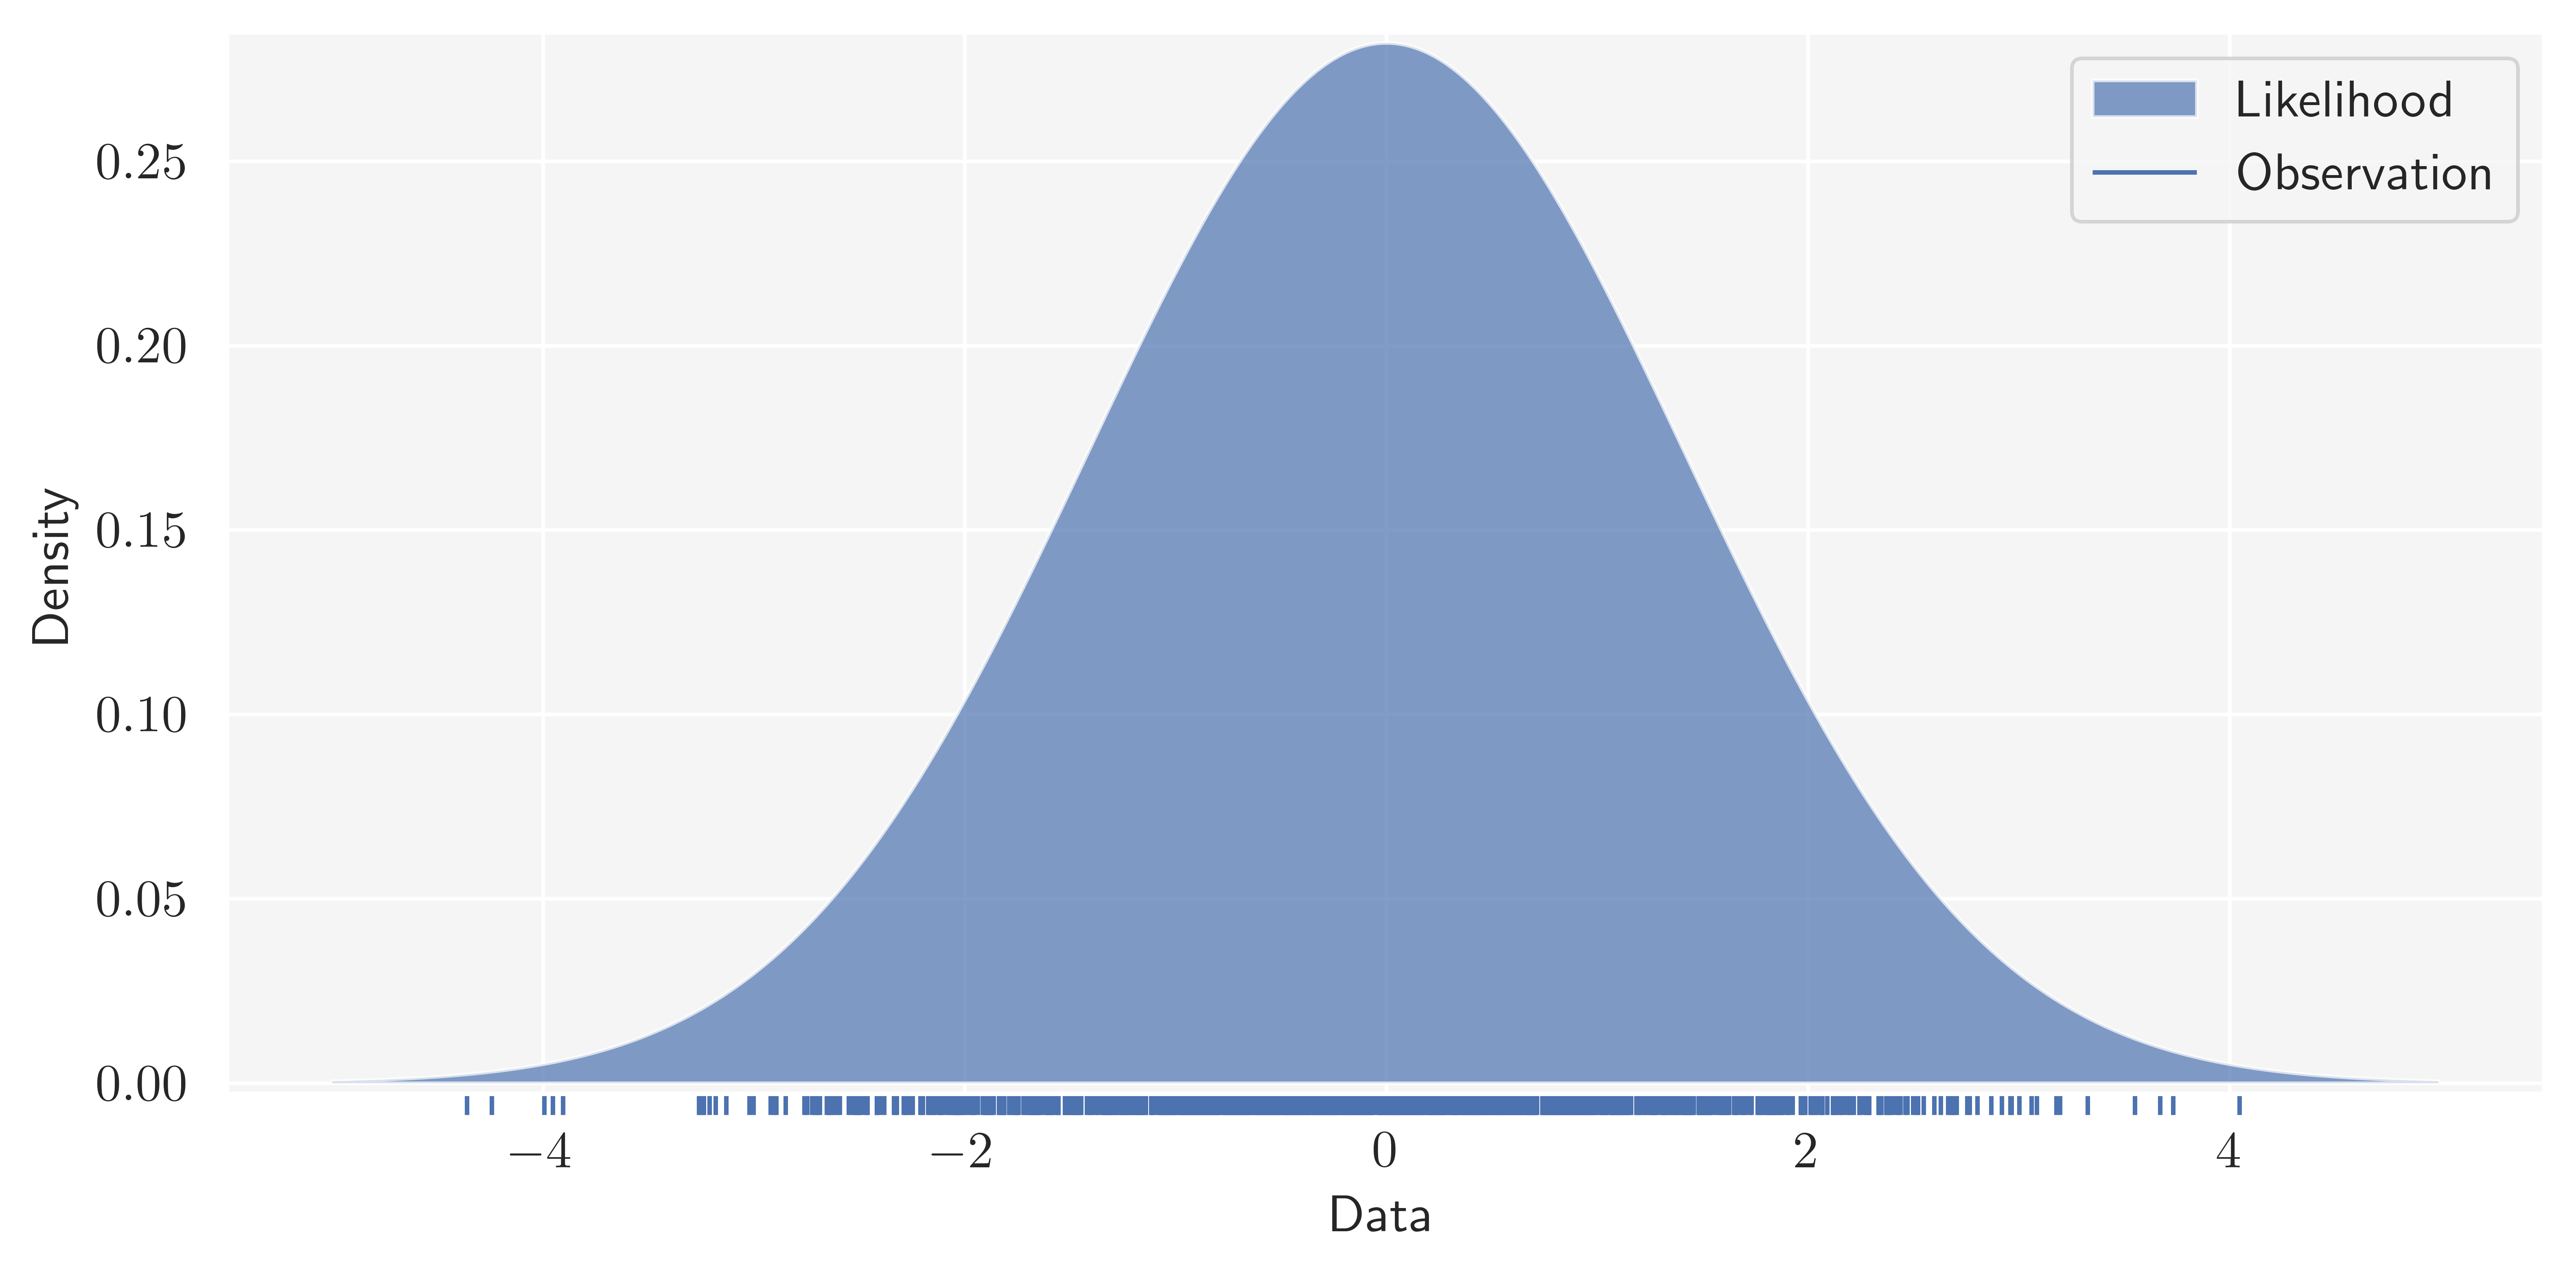

In [7]:
fig, ax = plt.subplots(figsize=(8, 4), tight_layout=True, dpi=800)

ax.fill_between(x, likelihood_pdf, alpha=0.7, label='Likelihood')
sns.rugplot(data=obs_data, ax=ax, height=-.02, clip_on=False, label='Observation')
ax.set_ylabel("Density")
ax.set_xlabel("Data")
ax.legend()
plt.show()

## Prior

In [8]:
alpha1 = 60  # prior hyperparameter
beta1 = 130  # prior hyperparameter

alpha2 = 110  # prior hyperparameter
beta2 = 220  # prior hyperparameter

a = 1 
b = 3

x_p = np.linspace(1, 3.5, 1000)  # specify domain

theta_prior1 = InvGamma(alpha1, loc=0, scale=beta1, name='theta1')
theta_prior2 = InvGamma(alpha2, loc=0, scale=beta2, name='theta2')
theta_prior3 = Uniform(loc=a, scale=b-a, name='theta3')

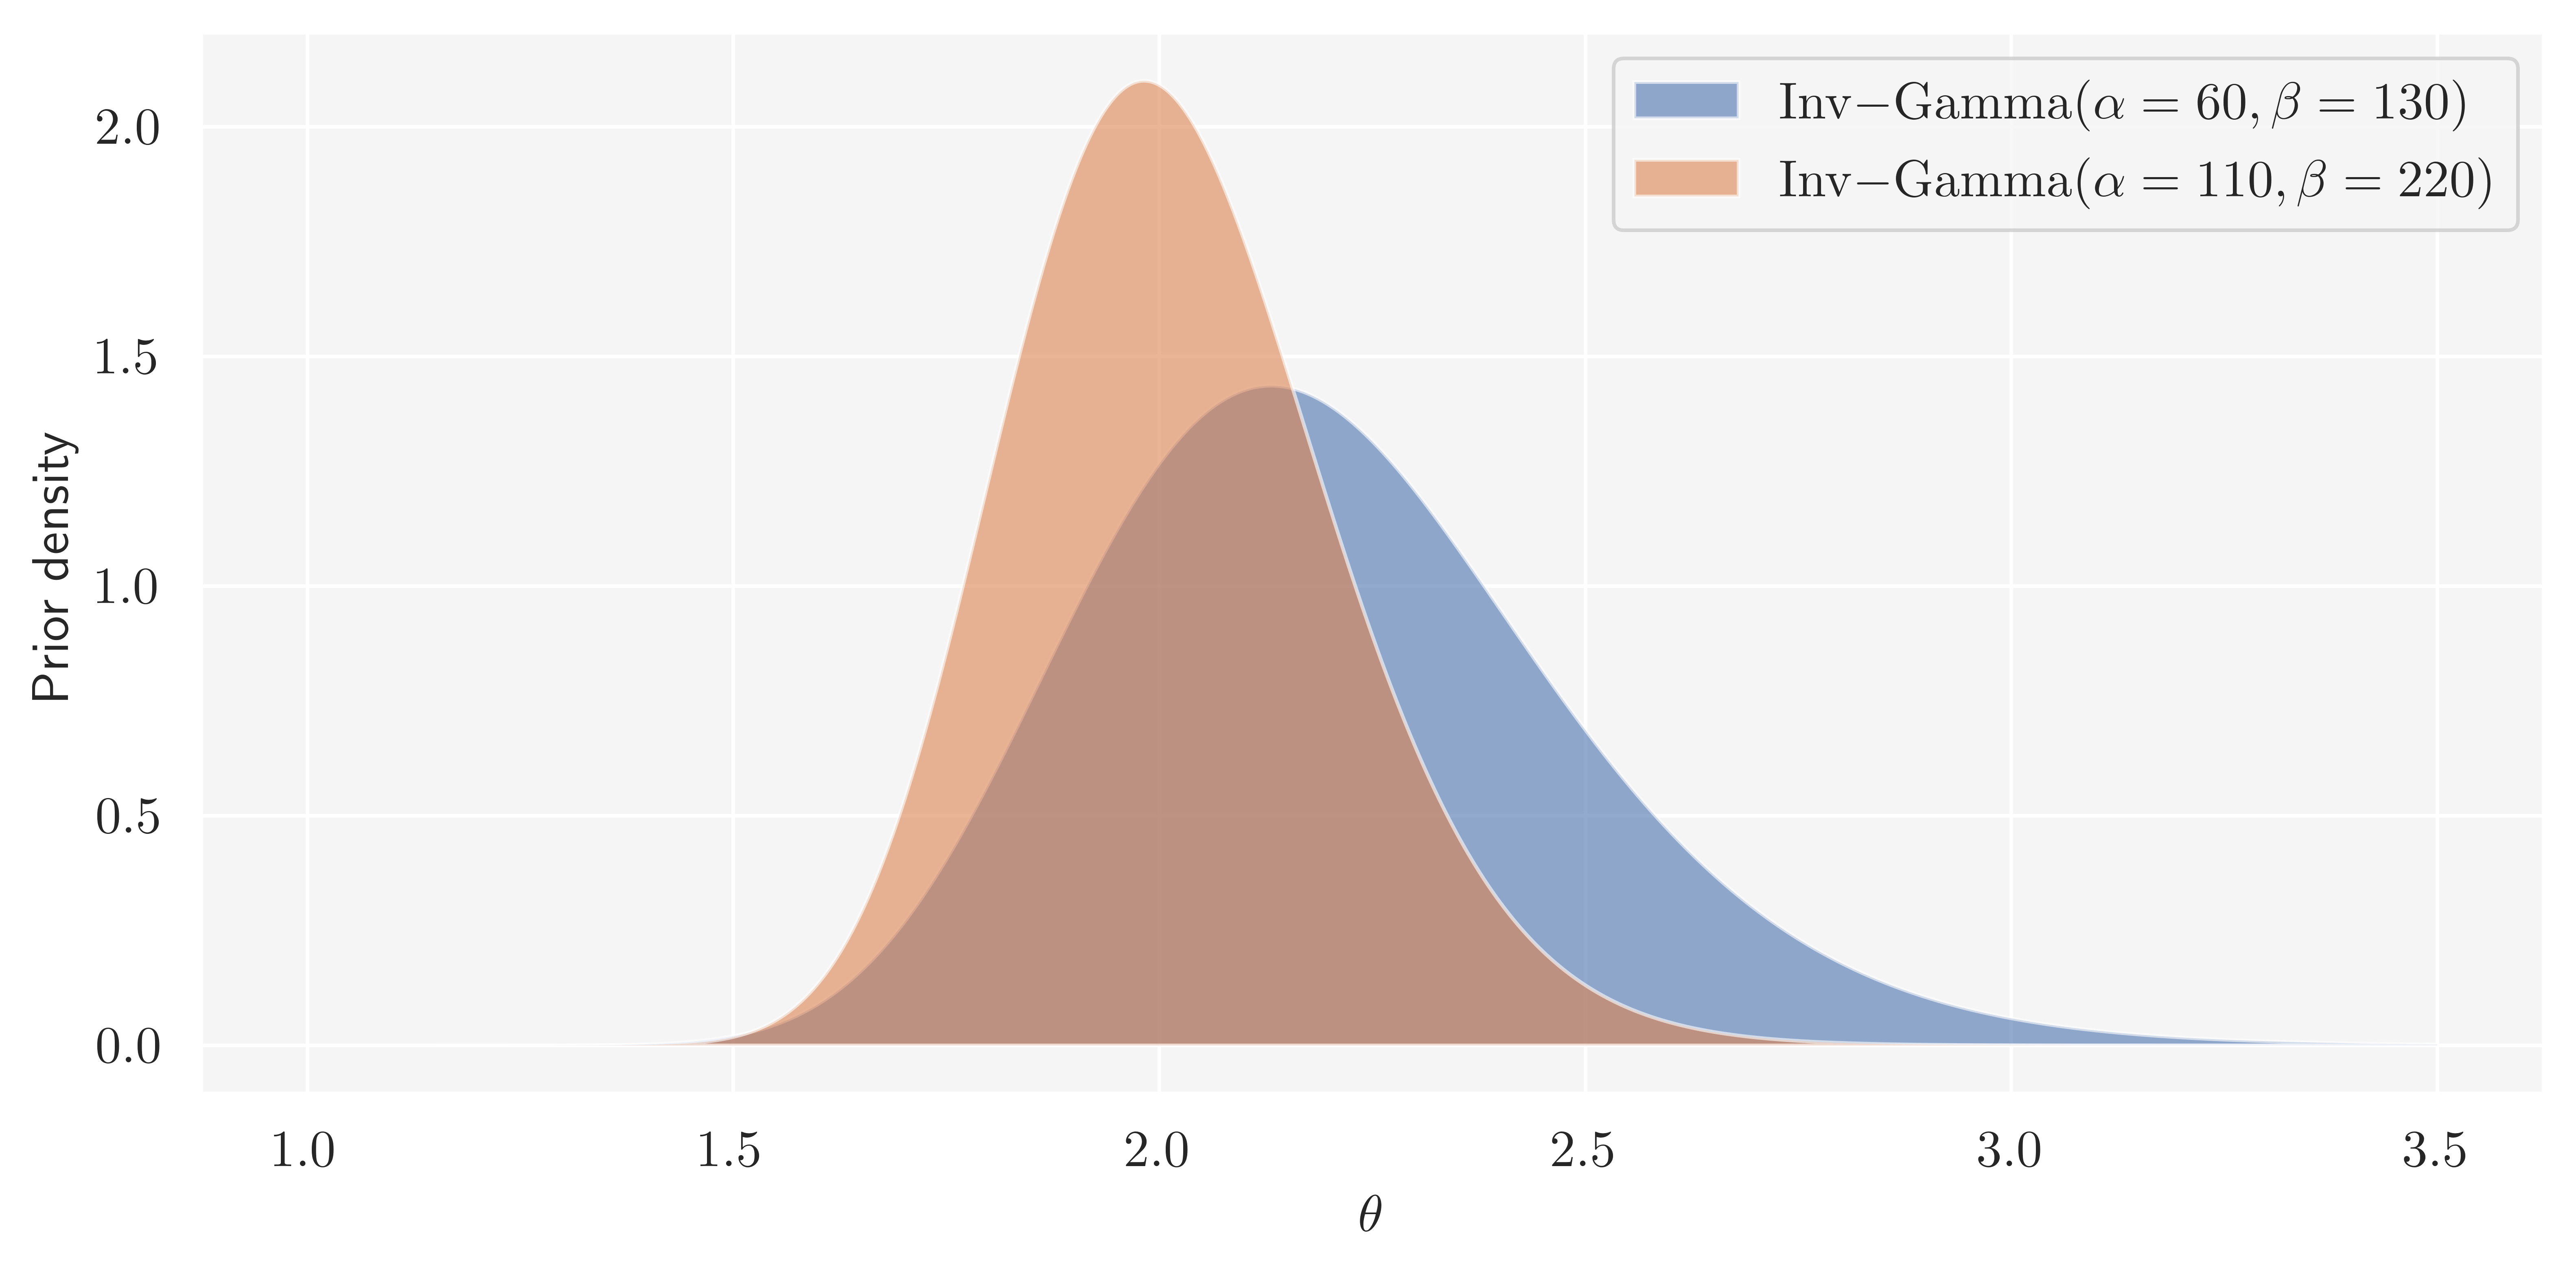

In [9]:
fig, ax = plt.subplots(figsize=(8, 4), tight_layout=True, dpi=800)
#ax.fill_between(x_p, theta_prior3.pdf(x_p), alpha=0.6, label=fr'$\mathrm{{U}}(a={a}, b={b})$')
ax.fill_between(x_p, theta_prior1.pdf(x_p), alpha=0.6, 
                label=fr'$\mathrm{{Inv}}\mathrm{{-Gamma}}(\alpha={alpha1}, \beta={beta1})$')
ax.fill_between(x_p, theta_prior2.pdf(x_p), alpha=0.6, 
                label=fr'$\mathrm{{Inv}}\mathrm{{-Gamma}}(\alpha={alpha2}, \beta={beta2})$')
ax.set_ylabel("Prior density")
ax.set_xlabel(r"$\theta$")
ax.legend()
plt.show()

## Closed-form Posterior

In [10]:
alphaprime1 = alpha1 + N / 2
betaprime1 = beta1 + 0.5 * np.sum(obs_data**2)
posterior1 = InvGamma(alphaprime1, loc=0, scale=betaprime1, name='posterior1') 

alphaprime2 = alpha2 + N / 2
betaprime2 = beta2 + 0.5 * np.sum(obs_data**2)
posterior2 = InvGamma(alphaprime2, loc=0, scale=betaprime2, name='posterior2')

x_post = np.linspace(1, 3, 1000)
posterior1_pdf = posterior1.pdf(x_post)
posterior2_pdf = posterior2.pdf(x_post)

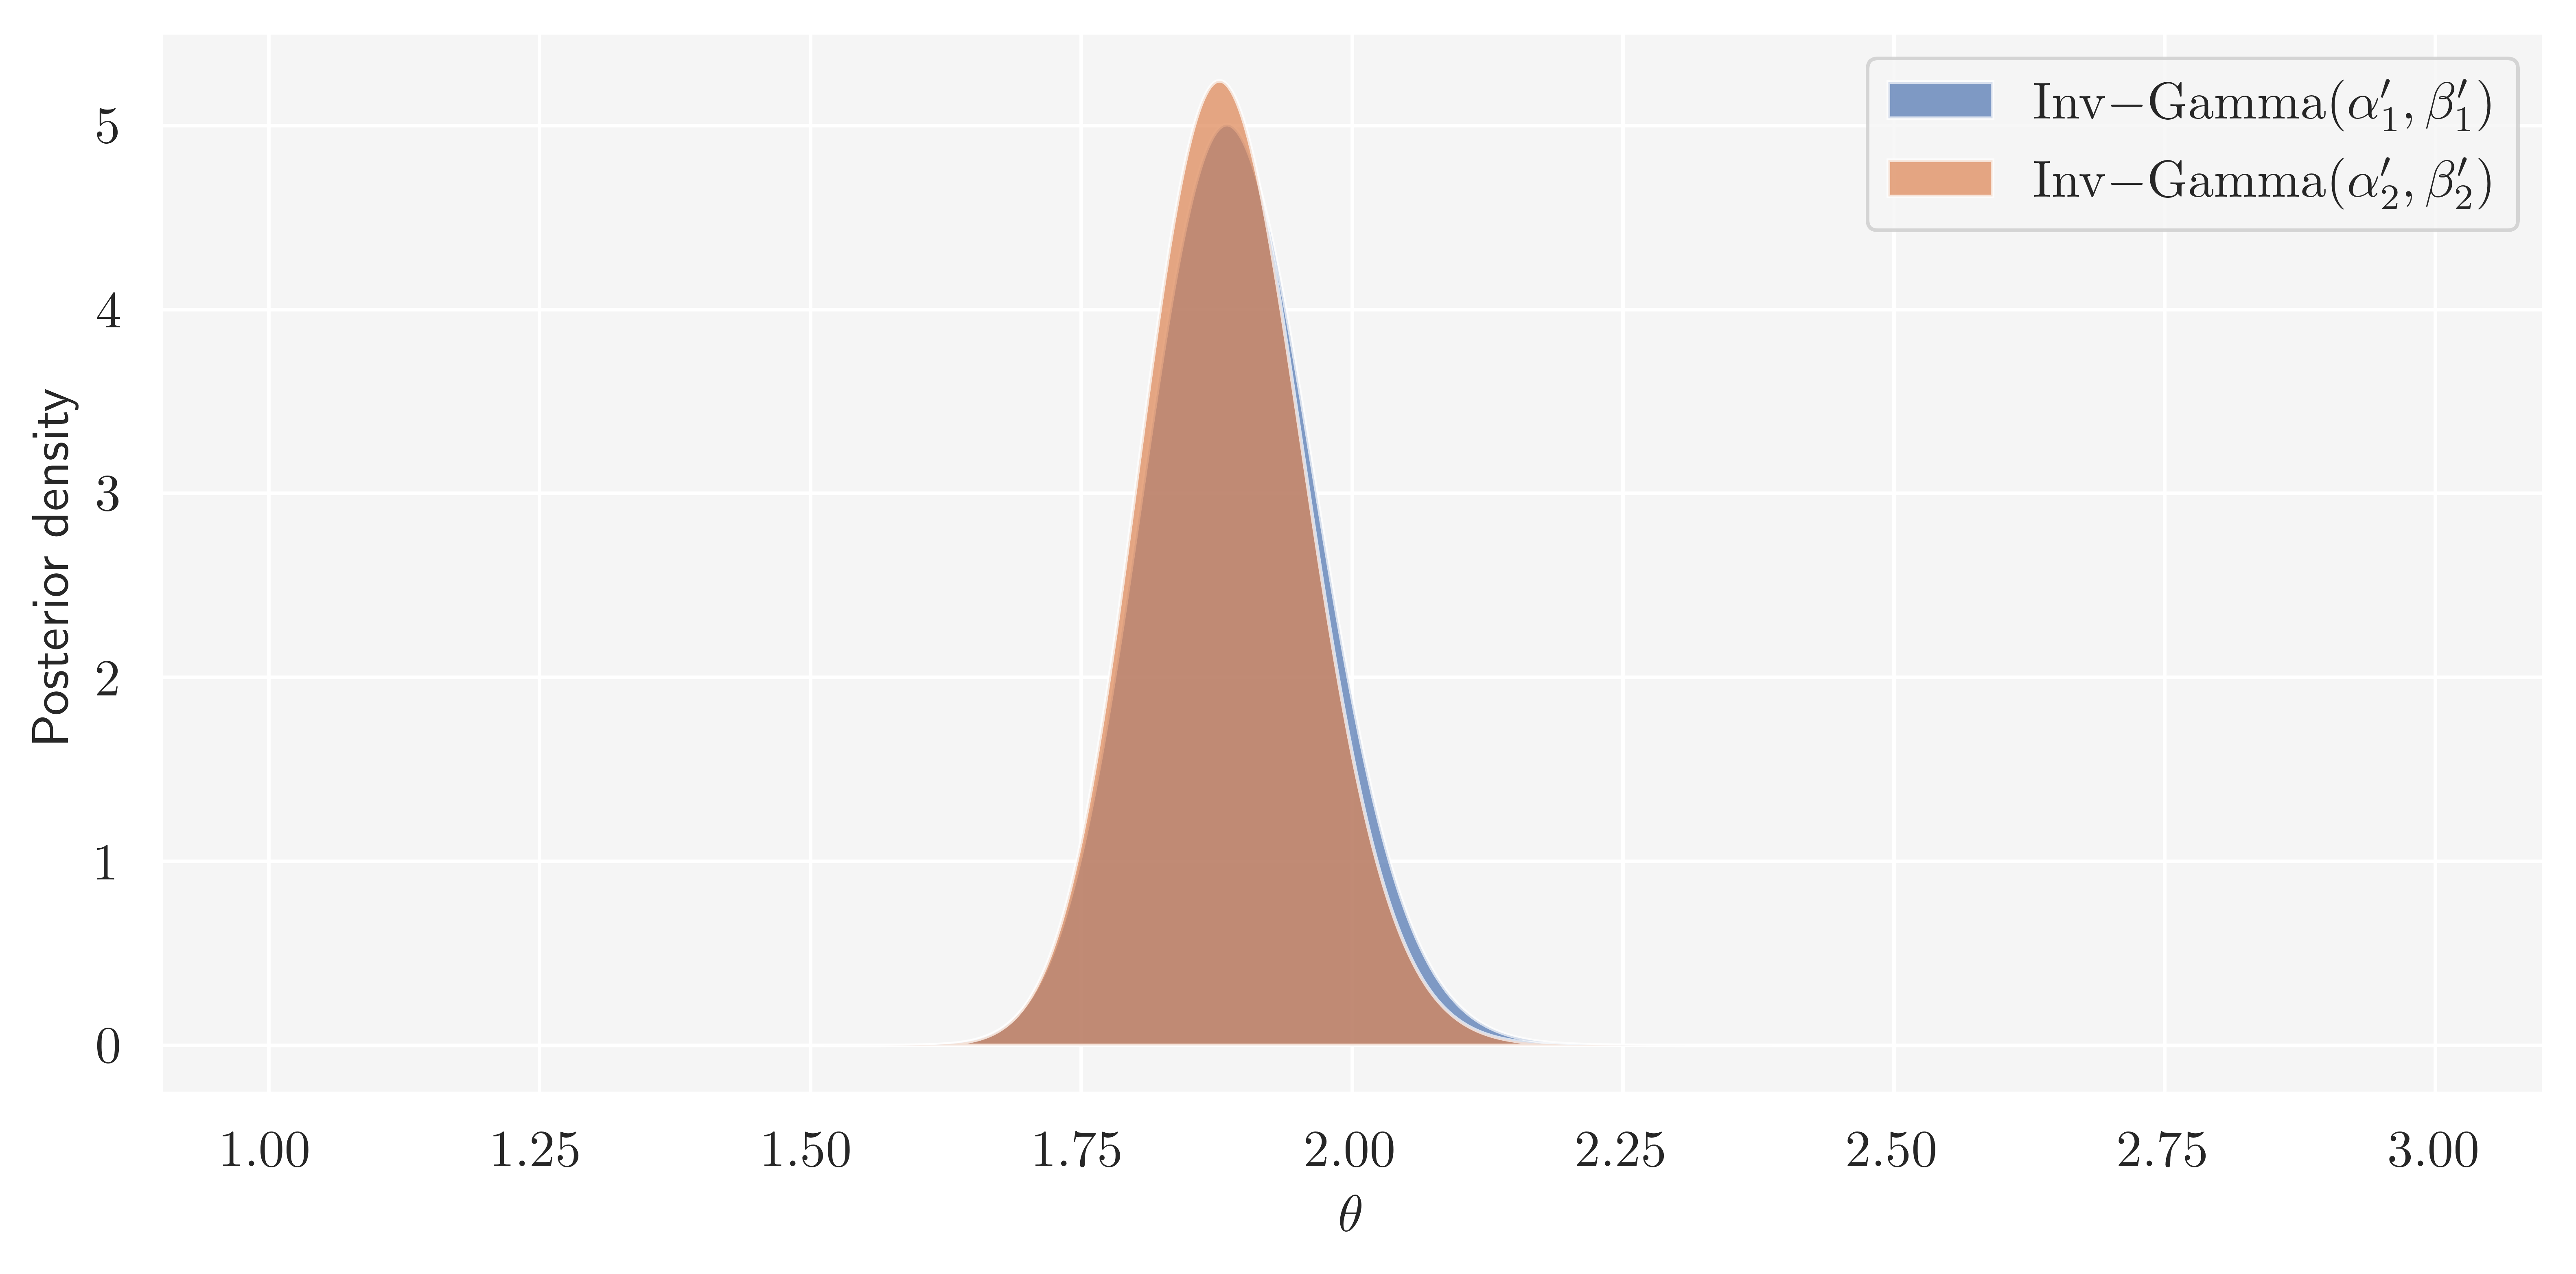

In [11]:
fig, ax = plt.subplots(figsize=(8, 4), tight_layout=True, dpi=800)
ax.fill_between(x_post, posterior1_pdf, alpha=0.7, 
                label=r"$\mathrm{Inv}\mathrm{-Gamma}(\alpha_1', \beta_1')$")
ax.fill_between(x_post, posterior2_pdf, alpha=0.7, 
                label=r"$\mathrm{Inv}\mathrm{-Gamma}(\alpha_2', \beta_2')$")
ax.set_ylabel("Posterior density")
ax.set_xlabel(r"$\theta$")
ax.legend()
plt.show()

## Summarizing the Posterior 

The result of a Bayesian analysis is a posterior distribution, and all the information about the parameters given a dataset and a model is contained in the posterior distribution. Thus, by summarizing the posterior, we are summarizing the logical consequences of a model and data. A common practice is to report, for each parameter, the mean (or mode or median) to have an idea of the location of the distribution and some measure, such as the standard deviation, to have an idea of the dispersion and hence the uncertainty in our estimate. The standard deviation works well for normal-like distributions but can be misleading for other type of distributions, such as skewed ones. So, an alternative is to use the following measure.

### Highest-Posterior Density

A commonly-used device to summarize the spread of a posterior distribution is to use a Highest-Posterior Density (HPD) interval. An HPD is the shortest interval containing a given portion of the probability density. One of the most commonly-used is the 95% HPD, often accompanied by the 50% HPD. If we say that the 95% HPD for some analysis is [2-5], we mean that according to our data and model, we think the parameter in question is between 2 and 5 with a probability of 0.95.

`ArviZ` is a Python package for exploratory data analysis for Bayesian models. ArviZ has many functions to help us summarize the posterior, for example, `az.plot_posterior` can be used to generate a plot with the mean and HPD of a distribution.

<Figure size 6400x3200 with 0 Axes>

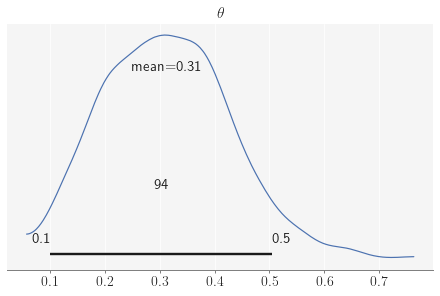

In [12]:
fig = plt.figure(figsize=(8, 4), tight_layout=True, dpi=800)
az.plot_posterior({r'$\theta$':stats.beta.rvs(5, 11, size=1000)})
plt.show()

<AxesSubplot:title={'center':'theta'}>

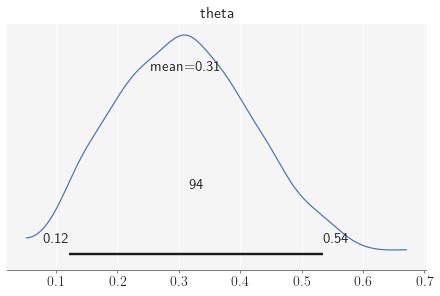

In [13]:
az.plot_posterior({'theta':stats.beta.rvs(5, 11, size=1000)})

## The impact of more observations 

Traditional Bayesian 
- likelihood kjent (statistisk)
- prior (standard)
-> posterior 

- mc metoder, variational inference  

LFI (likelihood-free inference)
- likelihood er "ukjent" 
- data generende prosess -> forward model -> simulator model
- summary statistic 
    - sufficient 
    
    p(theta | x) = p(theta | s)
    - approximate sufficient

## ABC

### Simulator Model

In [14]:
def summary_statistic(data):
    return np.var(data)


def simulator(theta, seed=42, N=10000):
    """Simulator model, returns summary statistic"""
    model = Normal(loc=0, scale=np.sqrt(theta), name='simulator')
    sim = model.rvs(size=N, seed=seed)
    sim_sumstat = summary_statistic(sim)
    return sim_sumstat

### Observation

In [15]:
observation = groundtruth

#obs_data = observation(N=int(1e4), seed=42)
#observation = summary_statistic(obs_data)

### Prior

In [16]:
alpha = 60  # prior hyperparameter
beta = 130  # prior hyperparameter

theta = InvGamma(alpha, loc=0, scale=beta, name='theta', tex=r'$\theta$')
priors = [theta]

### ABC Sampler with Specified Number of Simulations

In [17]:
# initialize sampler
sampler = RejectionABC(observation, simulator, priors, distance='l2', seed=42)

# inference config 1
num_simulations = 3000
epsilon = 0.2

# run inference
journal = sampler.sample(n_sims=num_simulations, epsilon=epsilon)

INFO:RejectionABC Initialize Rejection ABC sampler.
INFO:Journal  Create journal.
INFO:RejectionABC Run simulator with prior samples.


INFO:RejectionABC Accepted 1339 of 3000 simulations.
INFO:Journal  Processing sampler results.
INFO:Journal  Ready for post-sampling processing and analysis.
INFO:Journal  For details and tips, run 'journal.help'.


#### Sampler Summary

In [18]:
df = journal.sampler_summary 
df

Simulations  Posterior samples  Acceptance ratio  Wall time (s)
0         3000               1339          0.446333       1.750952

#### Sampler Parameter Statistics

In [19]:
df = journal.sampler_stats
df

theta
mean    2.010059
median  2.021346
var     0.012217
std     0.110532

#### Sampler Results (All Data)

In [20]:
df = journal.sampler_results
df

theta  epsilon  distance  relative distance  summary stats
0     2.091016      0.2  0.105310           0.105310       2.105310
1     1.916934      0.2  0.069961          -0.069961       1.930039
2     1.916910      0.2  0.069985          -0.069985       1.930015
3     1.789822      0.2  0.197943          -0.197943       1.802057
4     1.968357      0.2  0.018188          -0.018188       1.981812
...        ...      ...       ...                ...            ...
1334  2.106458      0.2  0.120857           0.120857       2.120857
1335  1.891652      0.2  0.095417          -0.095417       1.904583
1336  1.918177      0.2  0.068710          -0.068710       1.931290
1337  2.044585      0.2  0.058562           0.058562       2.058562
1338  2.029945      0.2  0.043821           0.043821       2.043821

[1339 rows x 5 columns]

### ABC Sampler with Specified Number of Posterior Samples

In [21]:
# initialize sampler
sampler = RejectionABC(observation, simulator, priors, distance='l2', seed=42)

# inference config 2
n_samples = 2000
epsilon = 0.5

# run inference
journal = sampler.sample(n_samples=n_samples, epsilon=epsilon)

INFO:RejectionABC Initialize Rejection ABC sampler.
INFO:RejectionABC Initialize Rejection ABC sampler.
INFO:Journal  Create journal.
INFO:Journal  Create journal.
INFO:RejectionABC Run sampler.
INFO:RejectionABC Run sampler.


INFO:RejectionABC Sampler ran 2364 simulations to obtain 2000 samples.
INFO:RejectionABC Sampler ran 2364 simulations to obtain 2000 samples.
INFO:Journal  Processing sampler results.
INFO:Journal  Processing sampler results.
INFO:Journal  Ready for post-sampling processing and analysis.
INFO:Journal  Ready for post-sampling processing and analysis.
INFO:Journal  For details and tips, run 'journal.help'.
INFO:Journal  For details and tips, run 'journal.help'.


#### Sampler Summary

In [22]:
df = journal.sampler_summary
df

Simulations  Posterior samples  Acceptance ratio  Wall time (s)
0         2364               2000          0.846024       1.882551

#### Sampler Parameter Statistics

In [23]:
df = journal.sampler_stats
df

theta
mean    2.104141
median  2.114307
var     0.044135
std     0.210083

### Summarizing the ABC posterior 

In [24]:
posterior_samples = journal.sampler_results["theta"].to_numpy()

<AxesSubplot:title={'center':'$\\theta$'}>

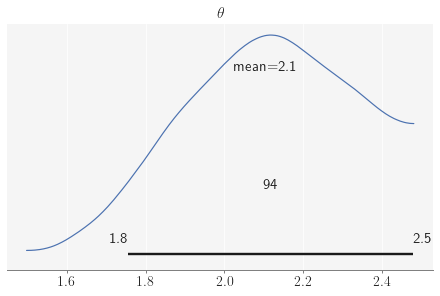

In [25]:
az.plot_posterior({r"$\theta$":posterior_samples})

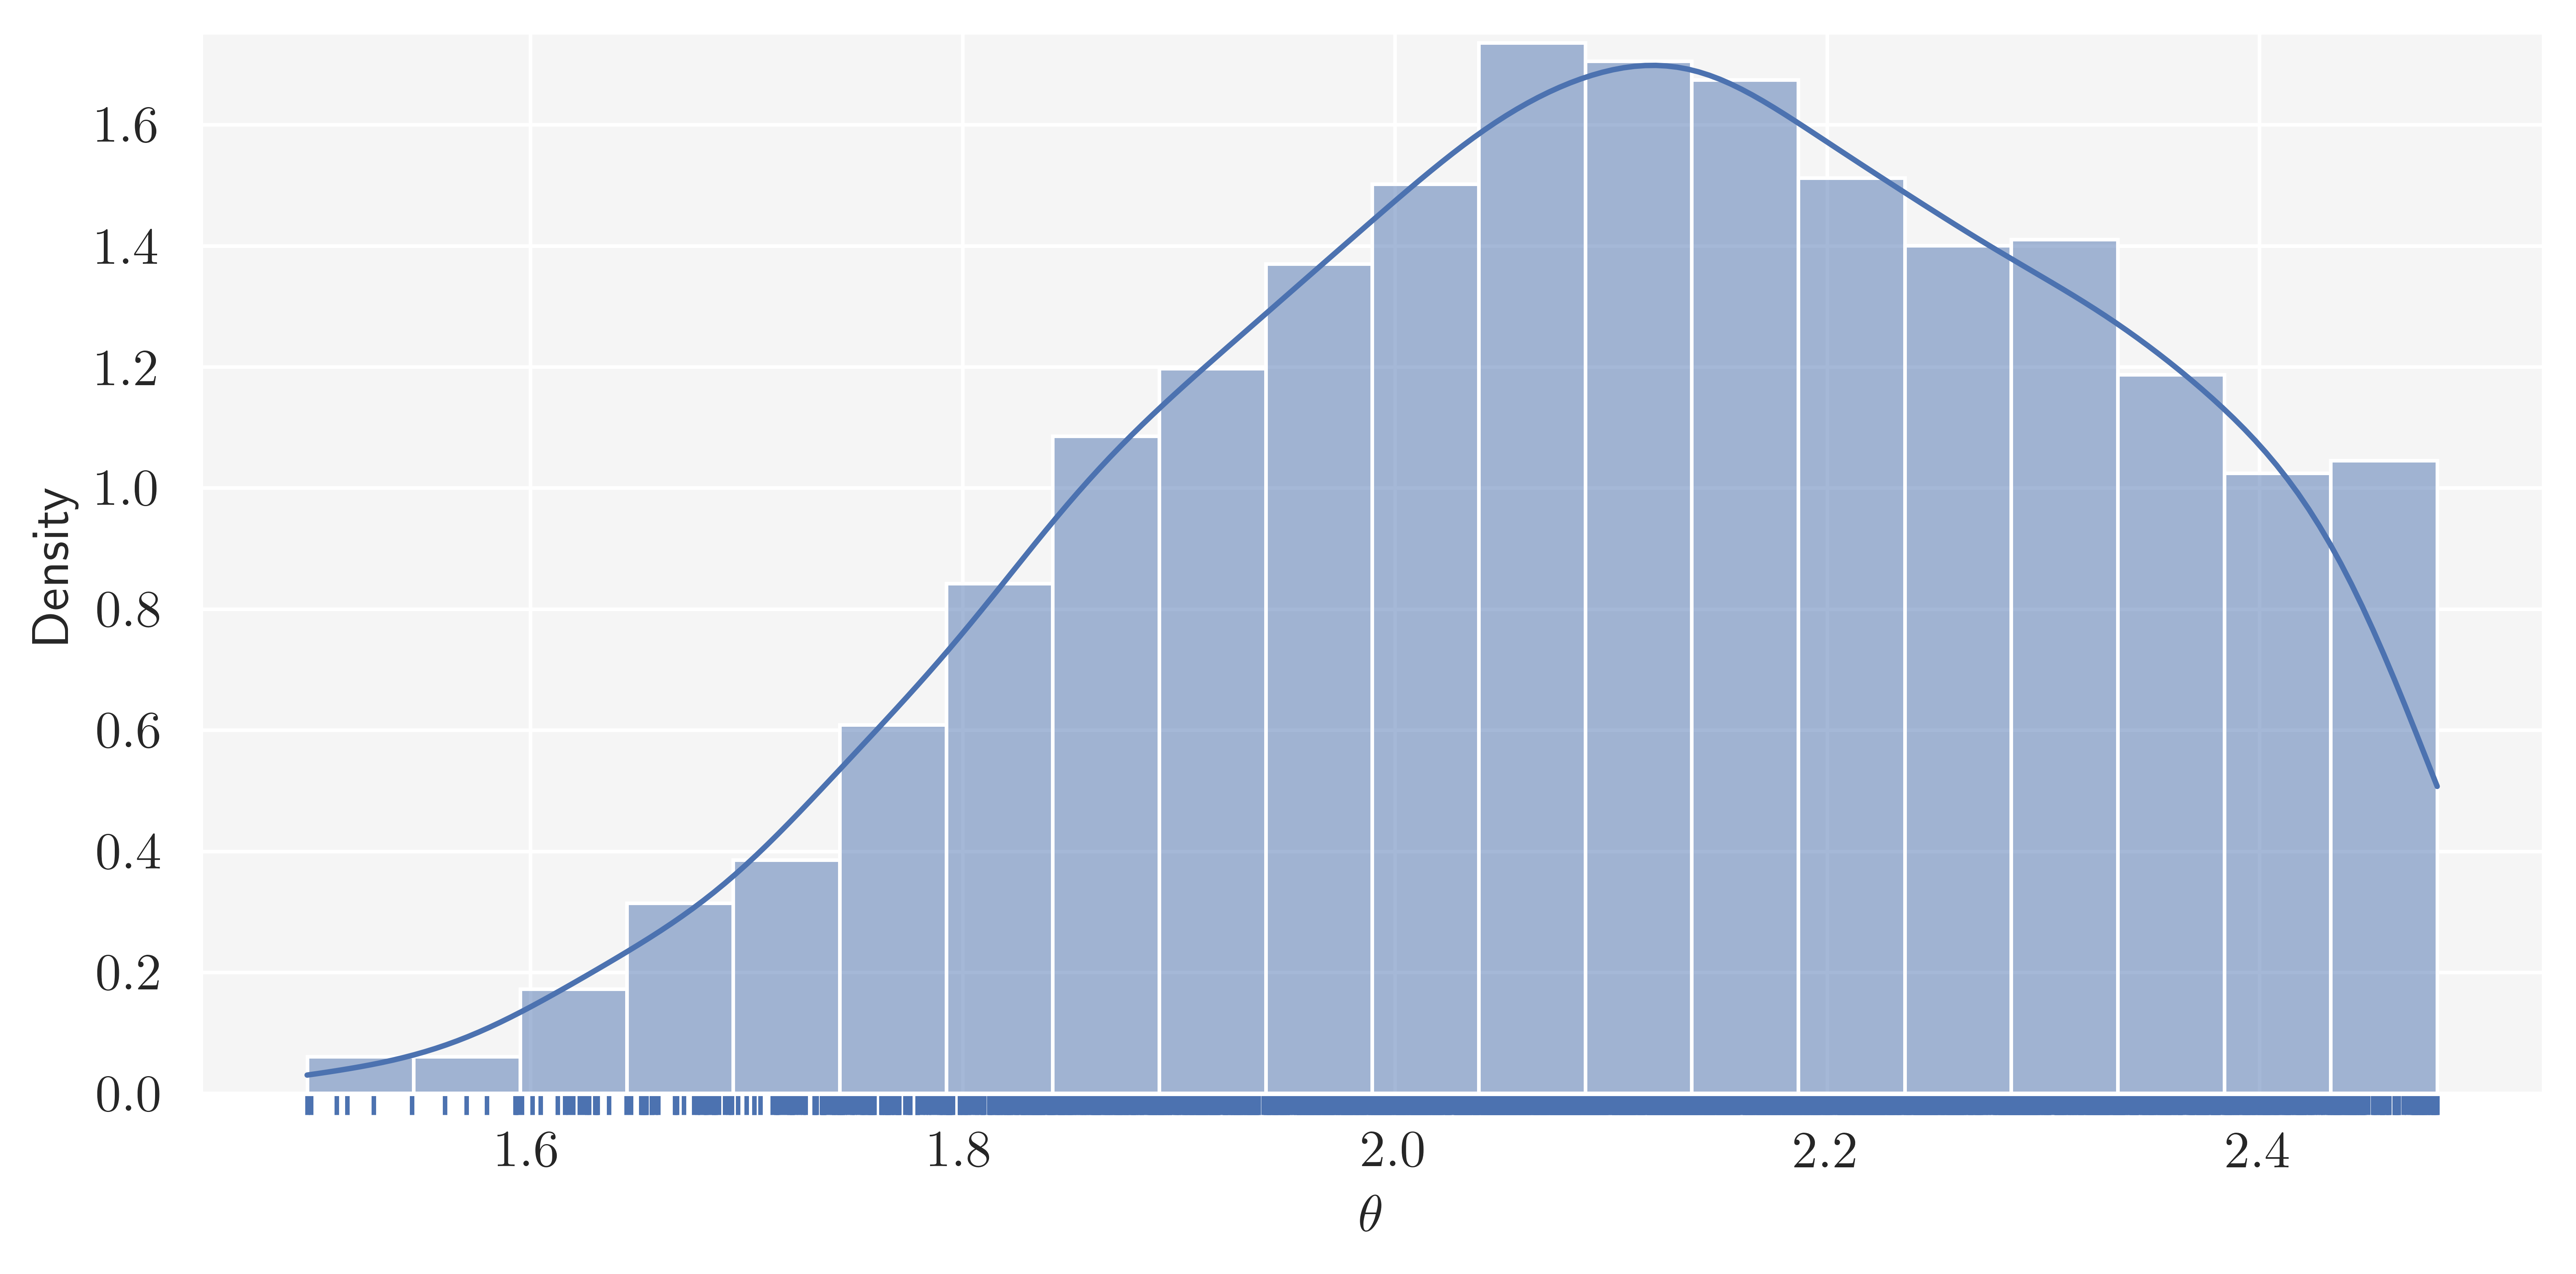

In [26]:
fig, ax = plt.subplots(figsize=(8, 4), tight_layout=True, dpi=800)
sns.histplot(data=posterior_samples, stat="density", kde=True, ax=ax)
sns.rugplot(data=posterior_samples, ax=ax, height=-.02, clip_on=False)
ax.set_xlabel(r"$\theta$")
plt.show()

### Post-Sampling Adjustment

#### Linear Relationship?

In [27]:
df = journal.sampler_results
df

theta  epsilon  distance  relative distance  summary stats
0     2.091016      0.5  0.105310           0.105310       2.105310
1     1.872698      0.5  0.114500          -0.114500       1.885500
2     2.477923      0.5  0.494862           0.494862       2.494862
3     2.415987      0.5  0.432503           0.432503       2.432503
4     1.870833      0.5  0.116378          -0.116378       1.883622
...        ...      ...       ...                ...            ...
1995  1.994797      0.5  0.008433           0.008433       2.008433
1996  2.144633      0.5  0.159294           0.159294       2.159294
1997  2.129662      0.5  0.144220           0.144220       2.144220
1998  2.247833      0.5  0.263199           0.263199       2.263199
1999  2.308430      0.5  0.324210           0.324210       2.324210

[2000 rows x 5 columns]

In [28]:
rel_dist = df["relative distance"].to_numpy()
sum_stats = df["summary stats"].to_numpy()

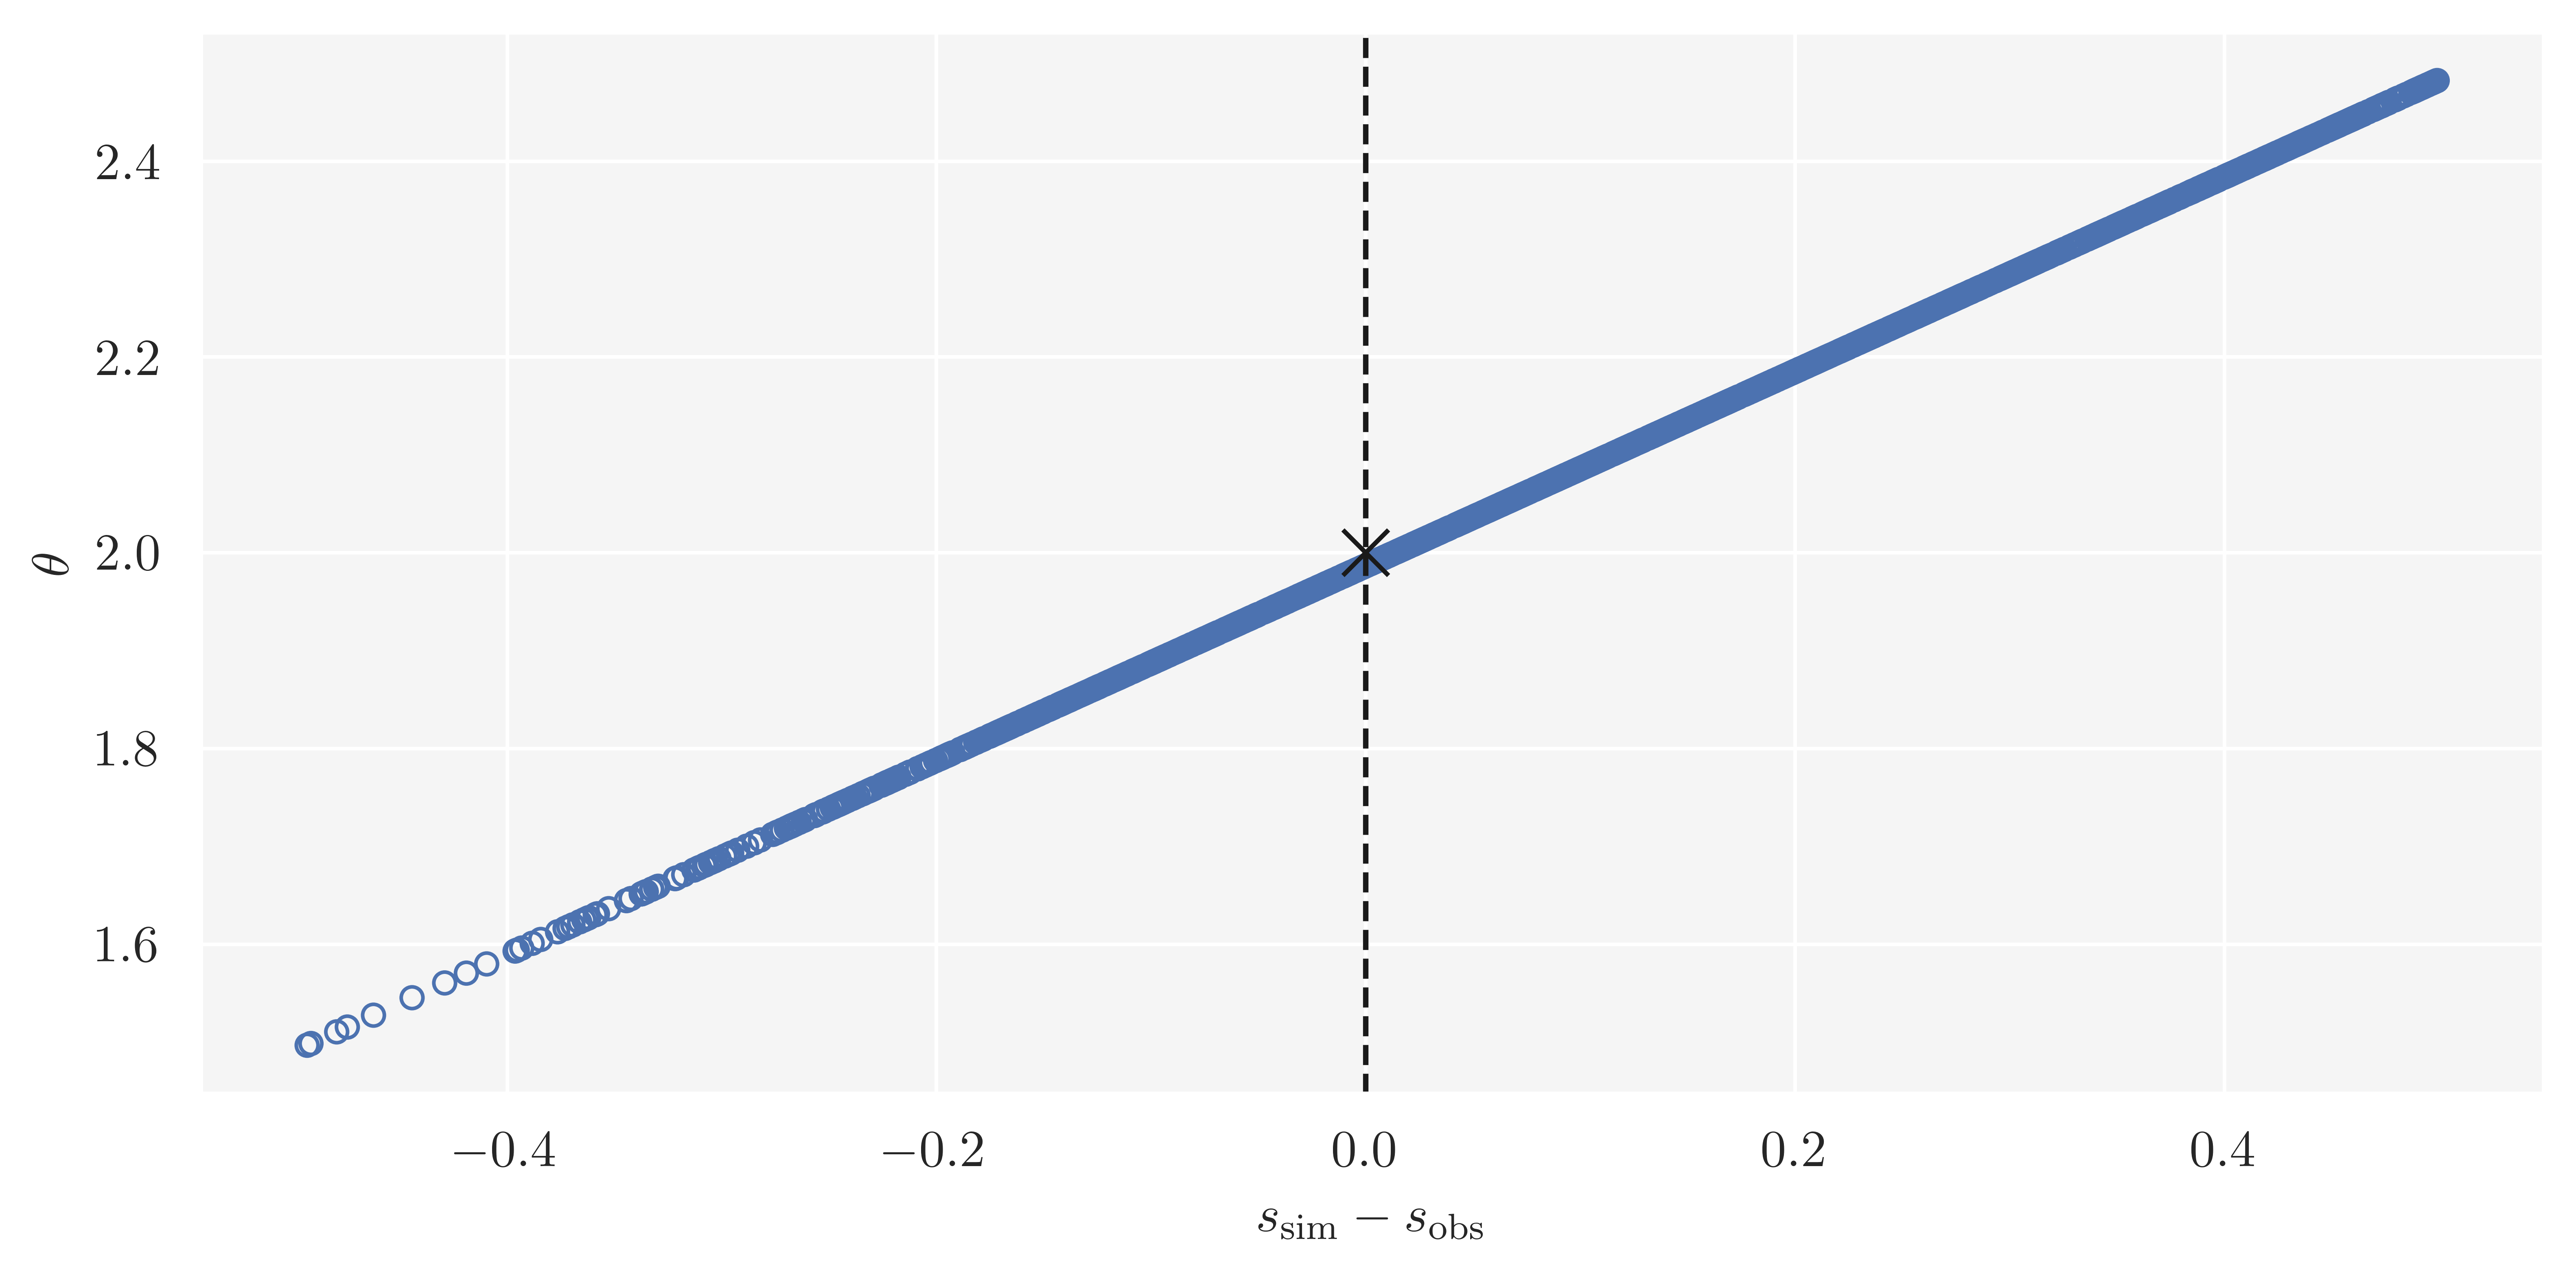

In [29]:
fig = plt.figure(figsize=(8, 4), tight_layout=True, dpi=800)
plt.scatter(rel_dist, posterior_samples, facecolors='none', edgecolor='C0')
plt.xlabel(r'$s_{\mathrm{sim}} - s_{\mathrm{obs}}$')
plt.ylabel(r'$\theta$')
plt.axvline(0, color='k', ls='--')
plt.plot(0, groundtruth, marker='x', markersize=10, color="k")
plt.show()

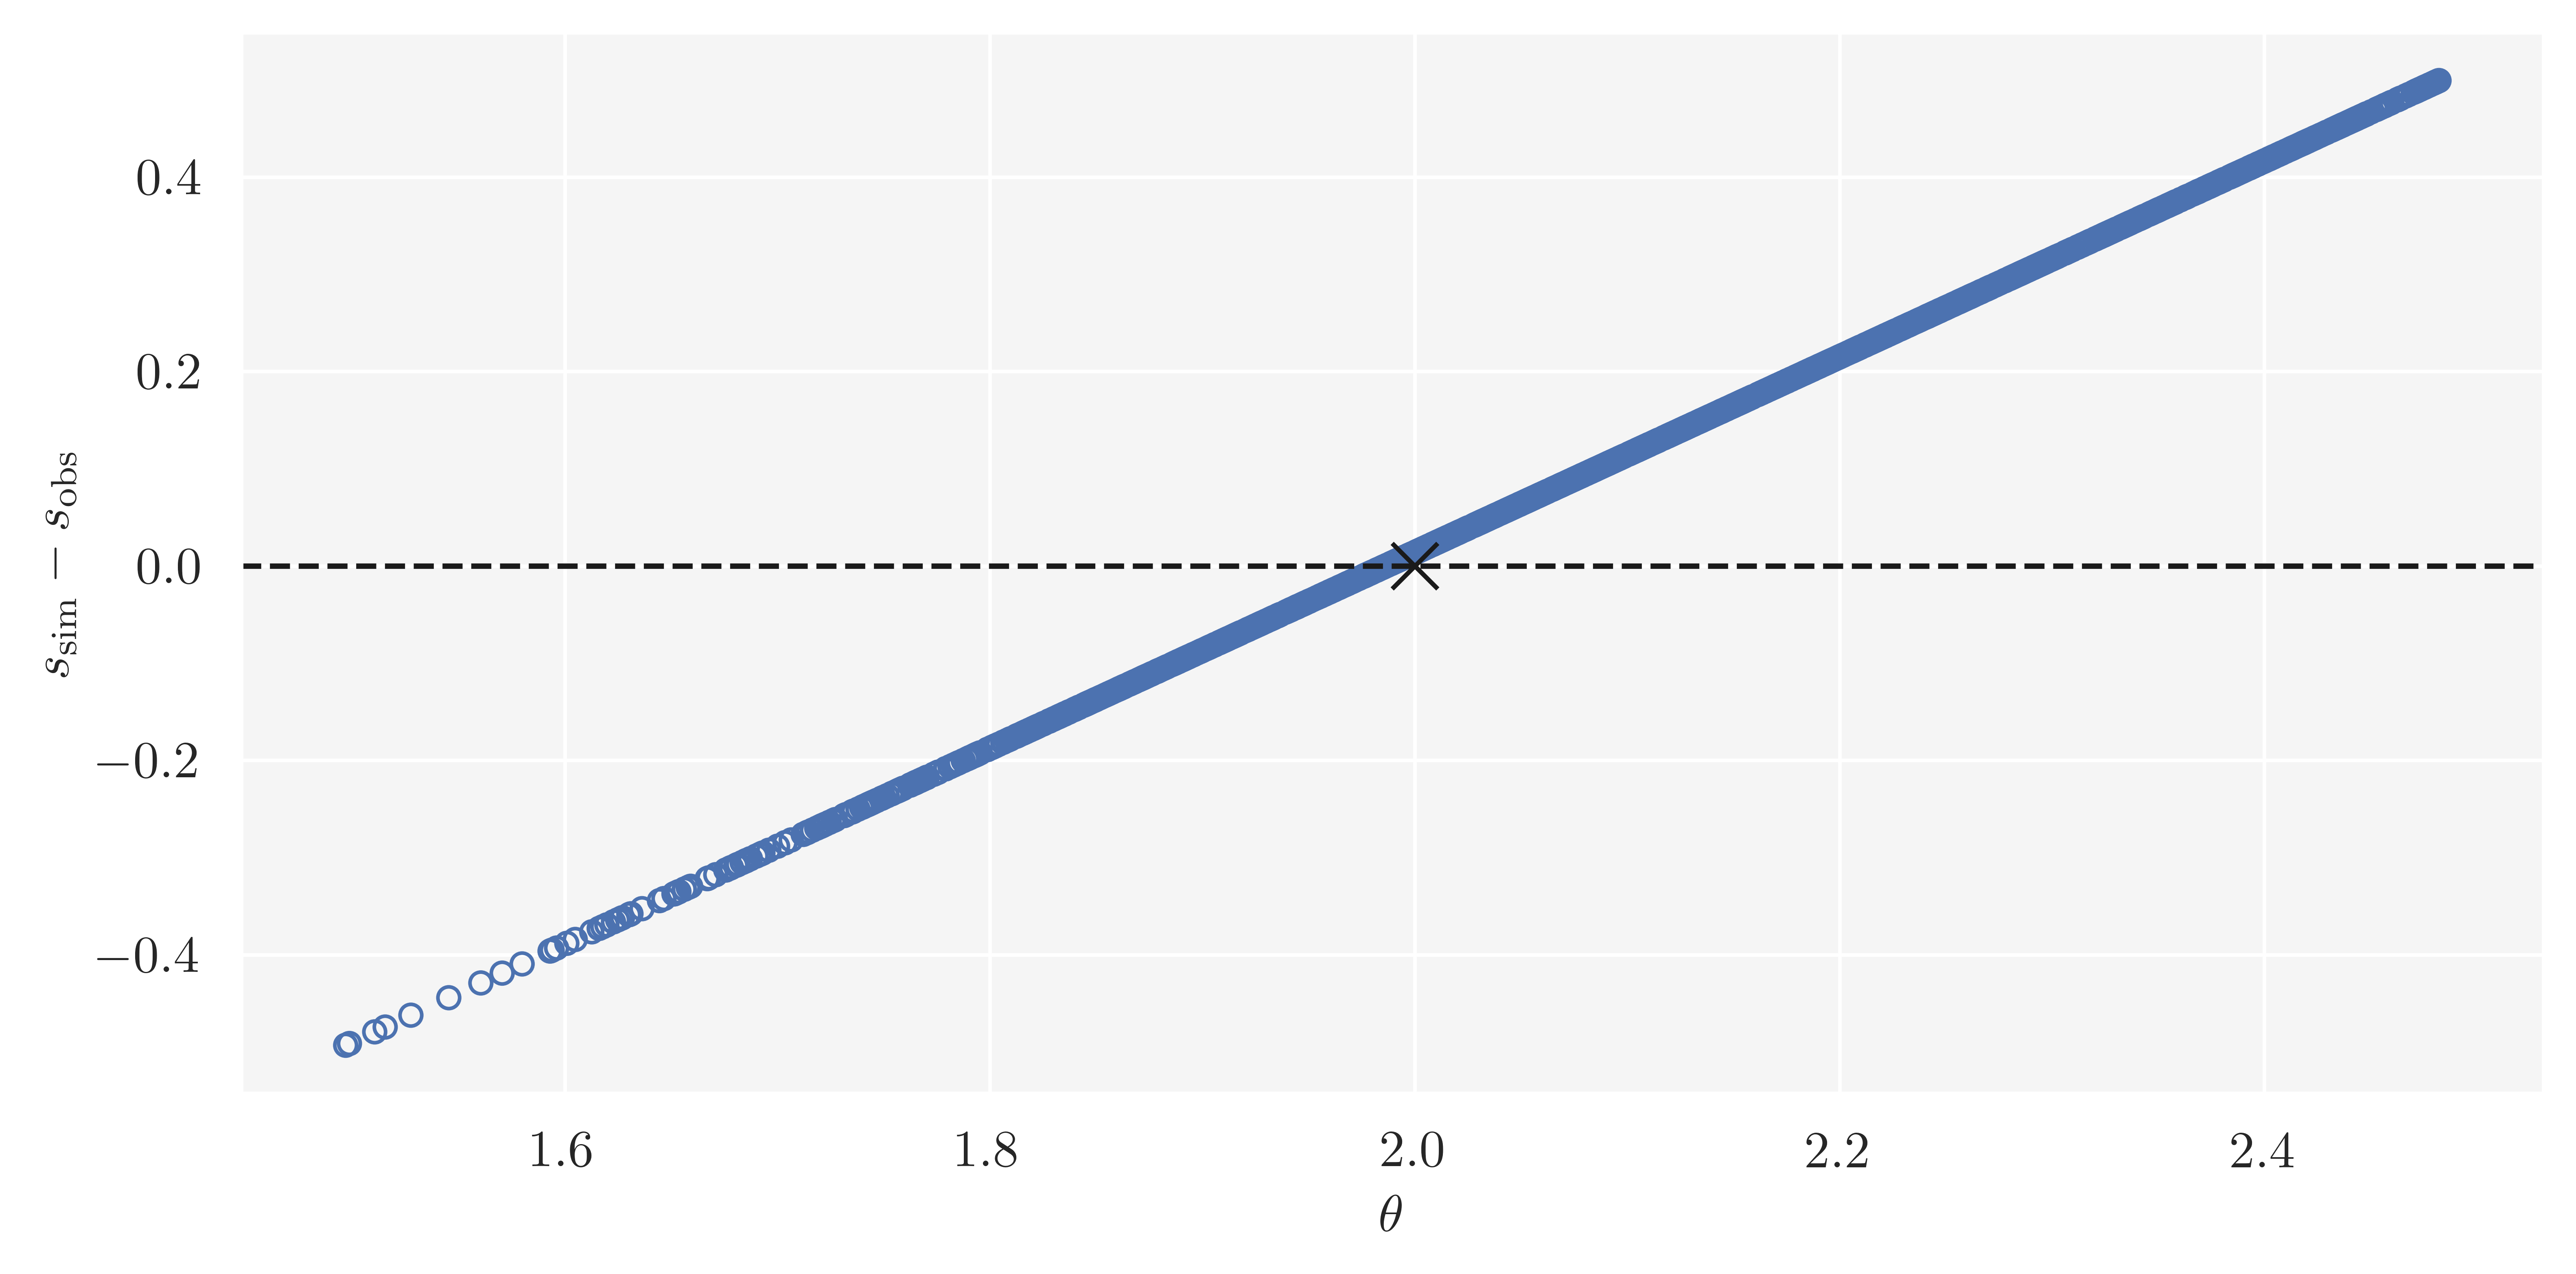

In [30]:
fig = plt.figure(figsize=(8, 4), tight_layout=True, dpi=800)
plt.scatter(posterior_samples, rel_dist, facecolors='none', edgecolor='C0')
plt.ylabel(r'$s_{\mathrm{sim}} - s_{\mathrm{obs}}$')
plt.xlabel(r'$\theta$')
plt.axhline(0, color='k', ls='--')
plt.plot(groundtruth, 0, marker='x', markersize=10, color="k")
plt.show()

#### Fit a Linear Regression Model 

References: Handbook of ABC and LFI for Cognitive Science

In the following we will denote the set of posterior samples as $\theta$, a set of summary statistics as $S(x)$, and the target (i.e., optimal) value for those summary statistics as $S_0$. Individual components of the summary statistics are represented with a double subscript reflecting the calculation for the $i$th sample and the $m$th statistic, such as $S_{i, m} (x)$. 

A simple model for linearly regressing the summary statistics $S(x)$ on the obtained posterior samples $\theta$ is 

\begin{equation}
    \theta_i = \alpha + (S_i (x) - S_0)^T \beta + \xi_i, \qquad i = 1, ..., N
\end{equation}

where the residuals $\xi$ are iid. When $S_i(x)=S_0$ we are drawing samples directly from our desired posterior distribution, whose mean we can denote $\alpha$. The least squares estimates for $\alpha$ and $\beta$ are 

\begin{equation}
    (\hat{\alpha}, \hat{\beta}) = (X^T X)^{-1} X^T \theta, 
\end{equation}

where $X$ is the matrix of summary statistics augmented with a column of ones: 

\begin{equation}
\begin{bmatrix}
    1 & S_{1, 1}(x) & S_{1, 2}(x) & \dots & S_{1, M}(x) \\
    1 & S_{2, 1}(x) & S_{2, 2}(x) & \dots & S_{2, M}(x) \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\ 
    1 & S_{N, 1}(x) & S_{N, 2}(x) & \dots & S_{N, M}(x)
\end{bmatrix}
\end{equation}

The strategy is then to adjust the set of posterior samples $\theta$ to have mean $\alpha$ while simultaneously correcting for the trend in the relationship between $\theta$ and $S(x)$. To do this, we calculate the correction 

\begin{equation}
    \theta^{*}_{i} = \theta - [S_i(x) - S_0]^T \hat{\beta}
\end{equation}

Following this adjustment, the new set of posterior samples $\theta^*$ will form a random sample from an approximation of the desired posterior distribution.

In [31]:
from sklearn.linear_model import LinearRegression
import copy

sum_stats = df["summary stats"].to_numpy()
posterior_samples = journal.sampler_results["theta"].to_numpy() 

theta_adjusted = copy.deepcopy(posterior_samples)

regression_model = LinearRegression(fit_intercept=True)
regression_model.fit(X=sum_stats[:, np.newaxis], y=posterior_samples)

theta_adjusted += regression_model.predict(np.array(observation).reshape(-1, 1))
theta_adjusted -= regression_model.predict(sum_stats[:, np.newaxis]) 

print(f"Adjusted posterior mean: {regression_model.intercept_}")
print(regression_model.coef_)

Adjusted posterior mean: -8.881784197001252e-16
[0.99321036]


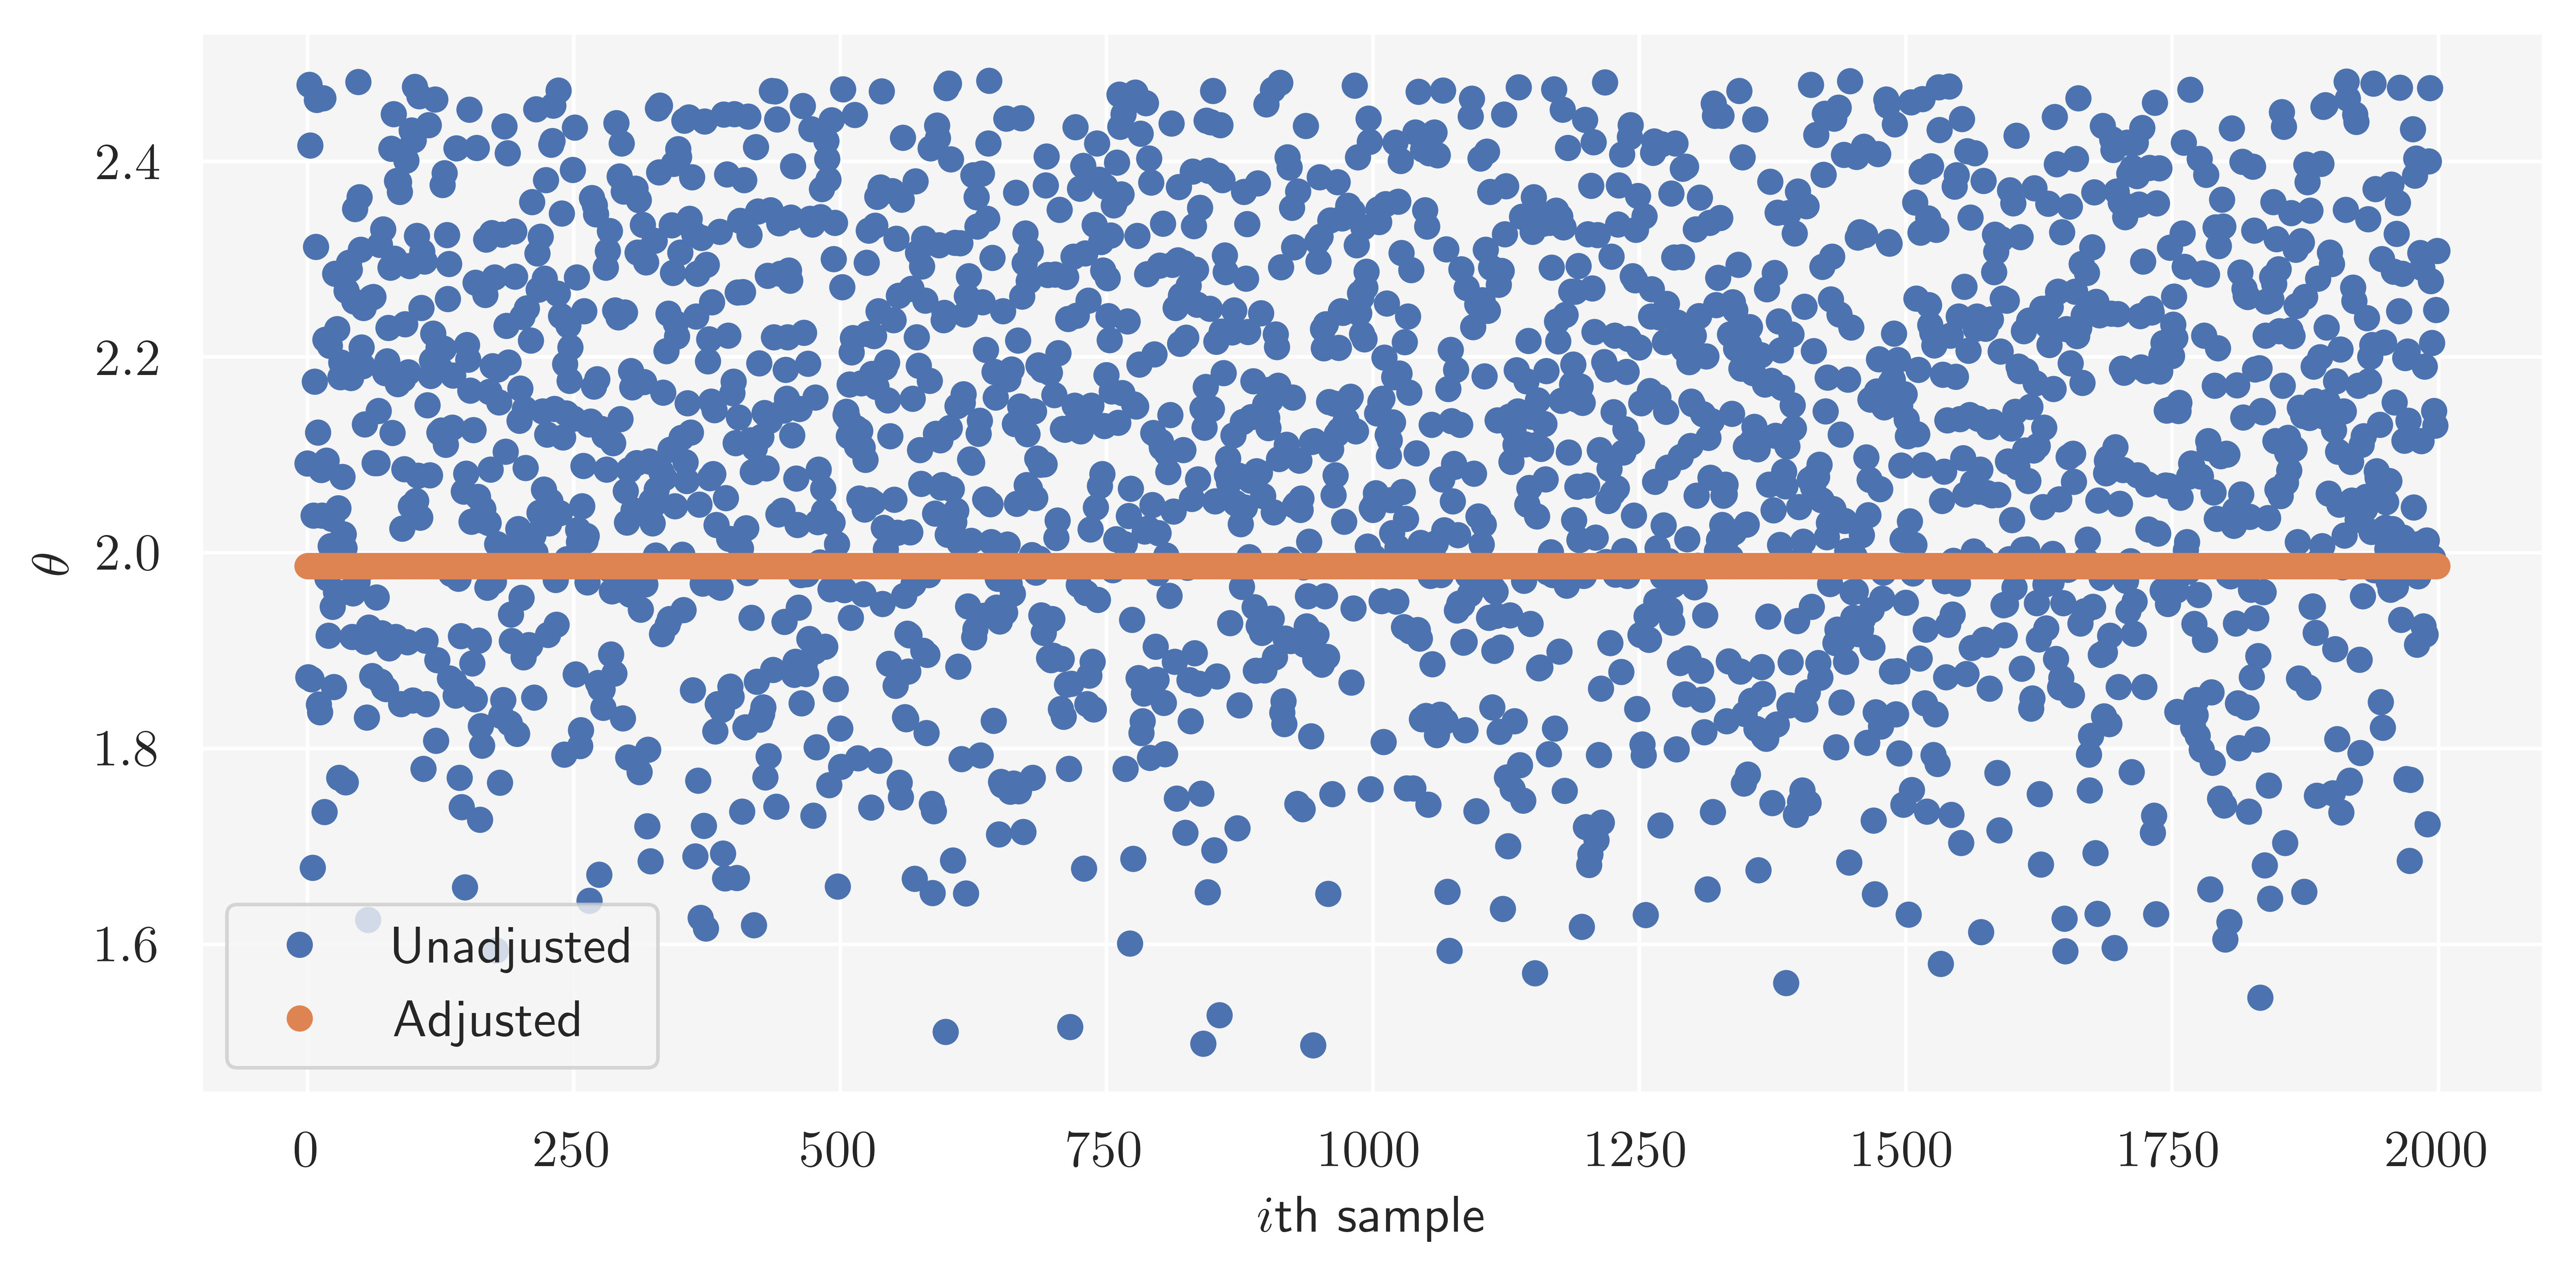

In [32]:
fig = plt.figure(figsize=(8, 4), tight_layout=True, dpi=800)
plt.plot(posterior_samples, 'o', label="Unadjusted")
plt.plot(theta_adjusted, 'o', label="Adjusted")
plt.ylabel(r"$\theta$")
plt.xlabel(r"$i$th sample")
plt.legend()
plt.show()

#### Own Implementation

In [66]:
class OLS():

    def __init__(self, standardize=False):
        self._coef = None
        self._intercept = None
        self._standardize = standardize
        
    def _process_data(self, X, y):
        r"""Process data.

        * Ensure correct shape of data `X`
        * Augment with a column of ones
        * Standardize data and target if kw `standardize=True`

        Parameters
        ----------
        X : array_like
            Data
        y : array_like
            Target

        Returns
        -------
        X : ndarray
            Processed data
        y : ndarray
            Processed target
        """
        X = np.asarray(X)
        y = np.asarray(y)

        if X.ndim == 1:
            X = X.reshape(-1, 1)

        # augment with column of ones
        X = np.c_[np.ones(X.shape[0]), X]

        if self._standardize:
            X_mean = np.mean(X[:, 1:], axis=0)
            X_sd = np.std(X_train[:, 1:], axis=0)
            X_stand = (X[:, 1:] - X_mean[np.newaxis, :]) / X_sd[np.newaxis, :]
            X = np.c_[np.ones(X.shape[0]), X_stand]

            y_mean = np.mean(y)
            y_sd = np.std(y)
            y_stand = (y - y_mean) / y_sd
            y = y_stand

        return X, y

    def fit(self, X, y):

        X, y = self._process_data(X, y)

        xTx = np.dot(X.T, X)
        inverse_xTx = np.linalg.pinv(xTx)
        xTy = np.dot(X.T, y)
        coef = np.dot(inverse_xTx, xTy)

        self._intercept = coef[0]
        self._coef = coef[1:]

    def predict(self, X):
        X = np.asarray(X)
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        return self.intercept + np.dot(X, self.coef)

    def posterior_mean(self):
        return self.intercept
    
    def adjust(self, theta, rel_dist): 
        return theta - rel_dist.T @ self.coef
    
    @property
    def intercept(self):
        return self._intercept 
    
    @property
    def coef(self):
        return self._coef

In [67]:
import copy

sum_stats = df["summary stats"].to_numpy()
posterior_samples = journal.sampler_results["theta"].to_numpy() 
rel_dist = journal.sampler_results["relative distance"].to_numpy() 

theta_adjusted = copy.deepcopy(posterior_samples)

linreg = OLS()
linreg.fit(X=sum_stats[:, np.newaxis], y=posterior_samples)
theta_adjusted += linreg.predict(np.array(observation).reshape(-1, 1))
theta_adjusted -= linreg.predict(sum_stats[:, np.newaxis]) 

theta_adjusted2 = linreg.adjust(posterior_samples, rel_dist.reshape(1, -1))

print(f"Adjusted posterior mean: {linreg.intercept}")
print(linreg.coef)

Adjusted posterior mean: 0.0
[0.99321036]


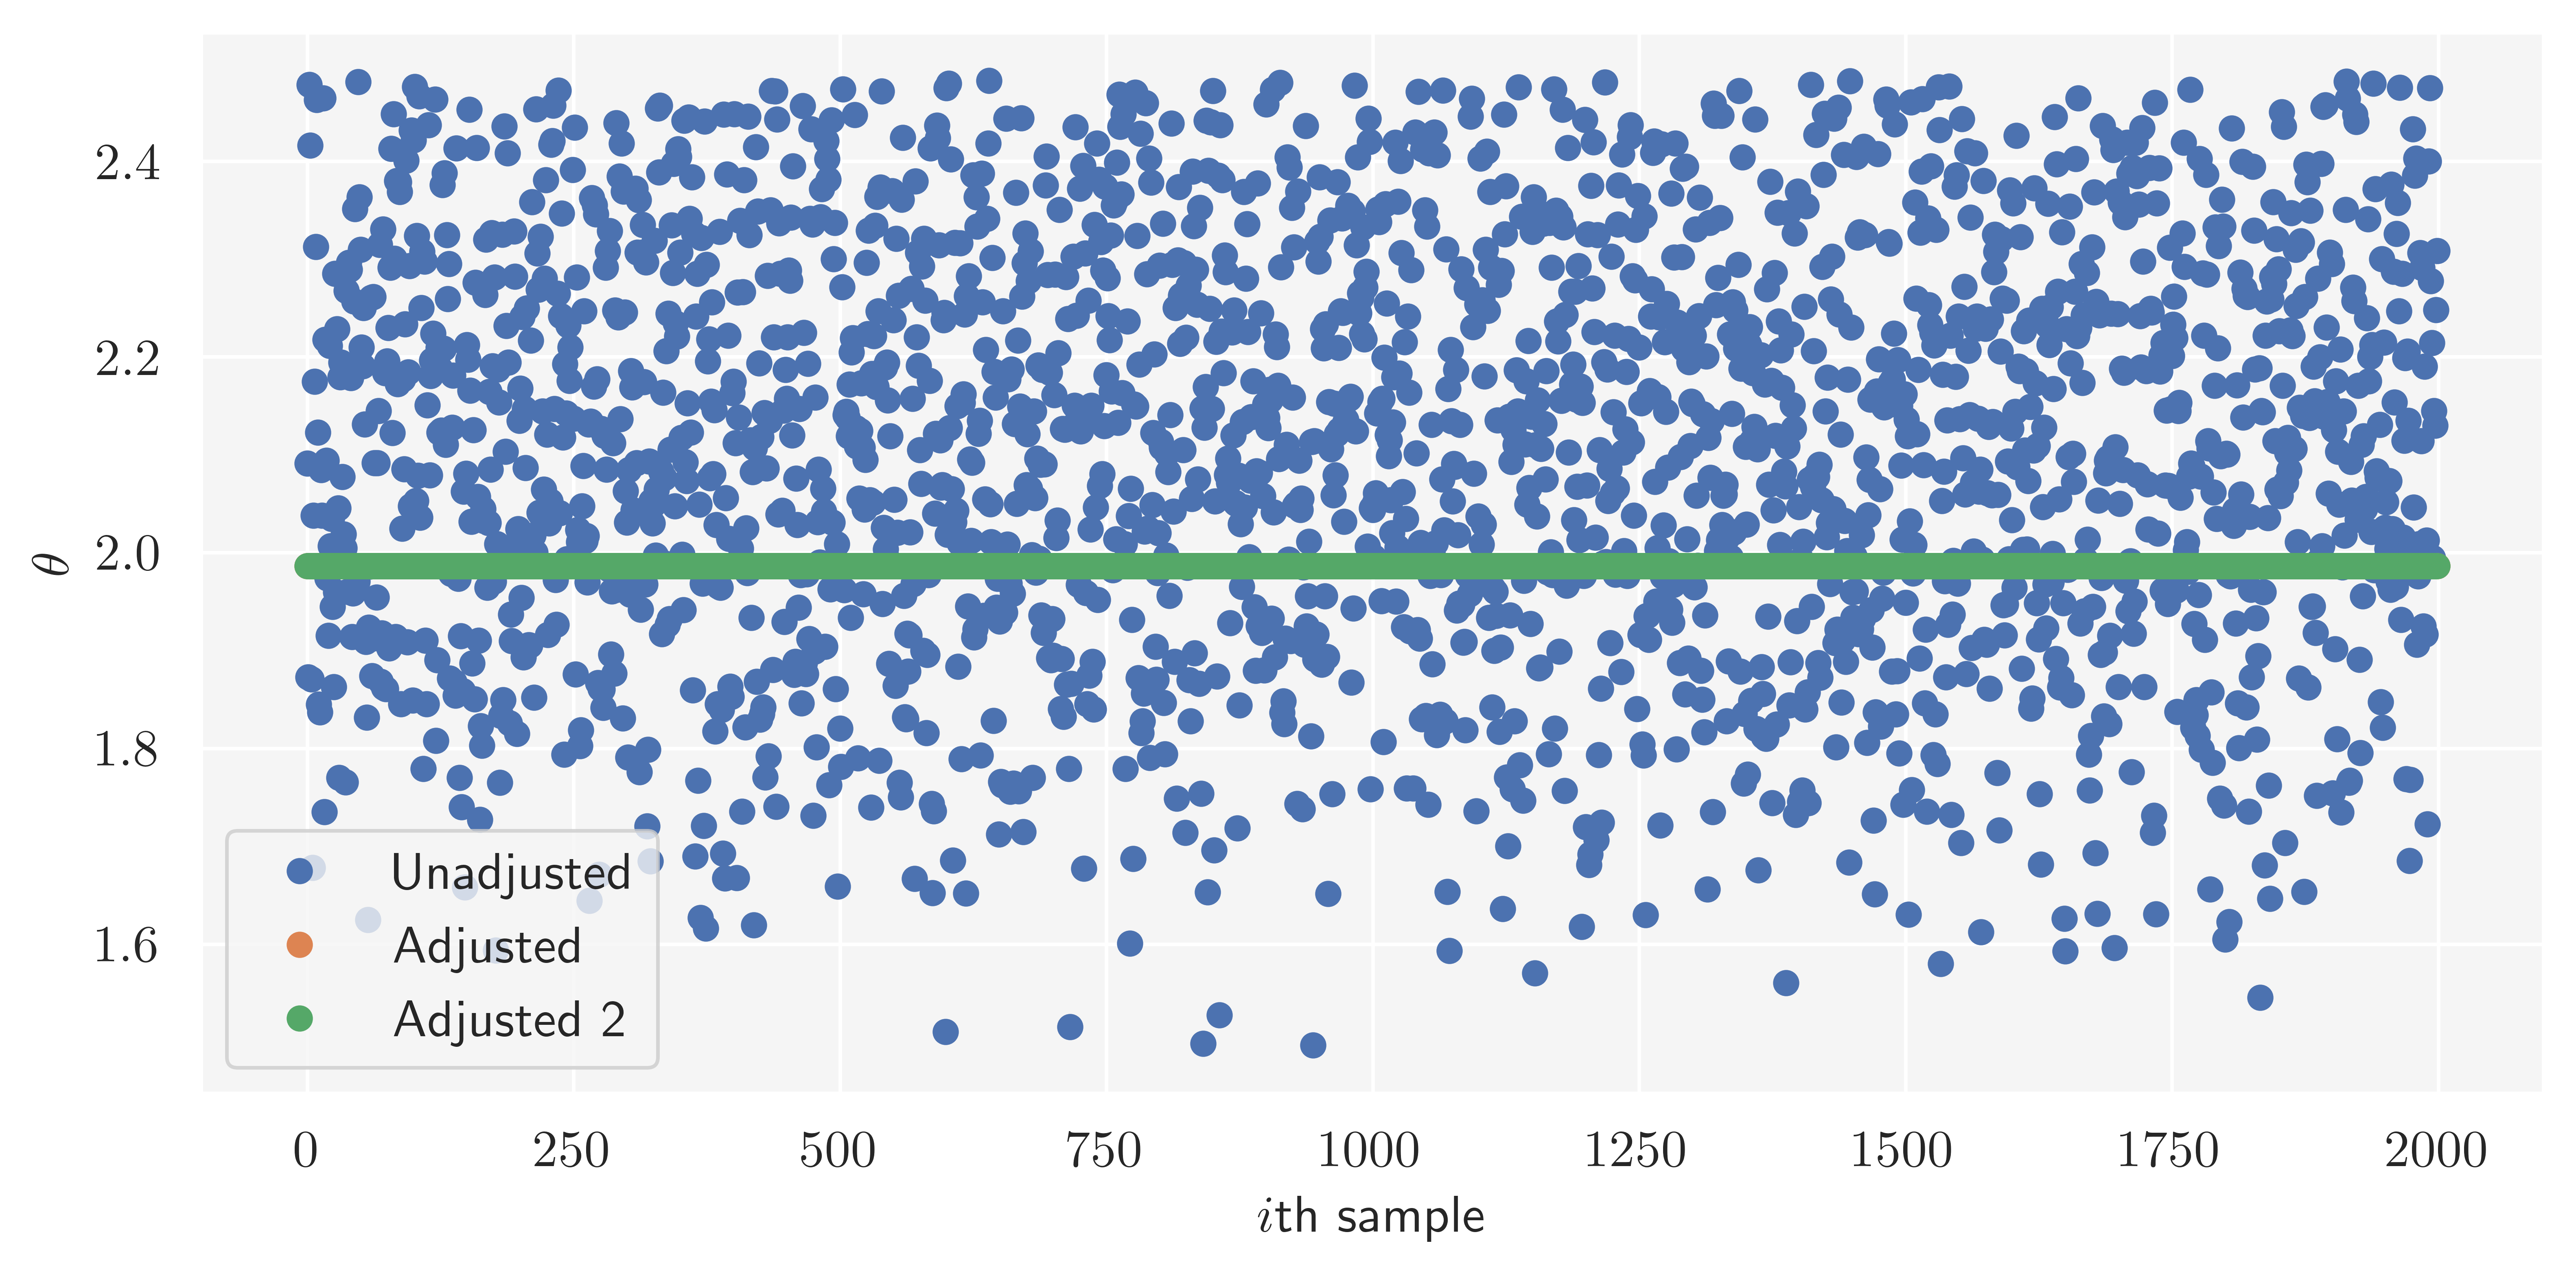

In [68]:
fig = plt.figure(figsize=(8, 4), tight_layout=True, dpi=800)
plt.plot(posterior_samples, 'o', label="Unadjusted")
plt.plot(theta_adjusted, 'o', label="Adjusted")
plt.plot(theta_adjusted2, 'o', label="Adjusted 2")
plt.ylabel(r"$\theta$")
plt.xlabel(r"$i$th sample")
plt.legend()
plt.show()

In [77]:
print(theta_adjusted2)

[1.98642072 1.98642072 1.98642072 ... 1.98642072 1.98642072 1.98642072]


In [65]:
rel_dist = journal.sampler_results["relative distance"].to_numpy() 
rel_dist = rel_dist.reshape(1, -1)
print(rel_dist.shape)
rel_dist_T = rel_dist.T
print(rel_dist.shape)

coef = linreg.coef
print(coef.shape)

corr = rel_dist_T @ coef
print(corr.shape)

theta = journal.sampler_results["theta"].to_numpy() 
print(theta.shape)

theta_adj = theta - corr 
print(theta_adj.shape)

print(theta_adj)

(1, 2000)
(1, 2000)
(1,)
(2000,)
(2000,)
(2000,)
[1.98642072 1.98642072 1.98642072 ... 1.98642072 1.98642072 1.98642072]


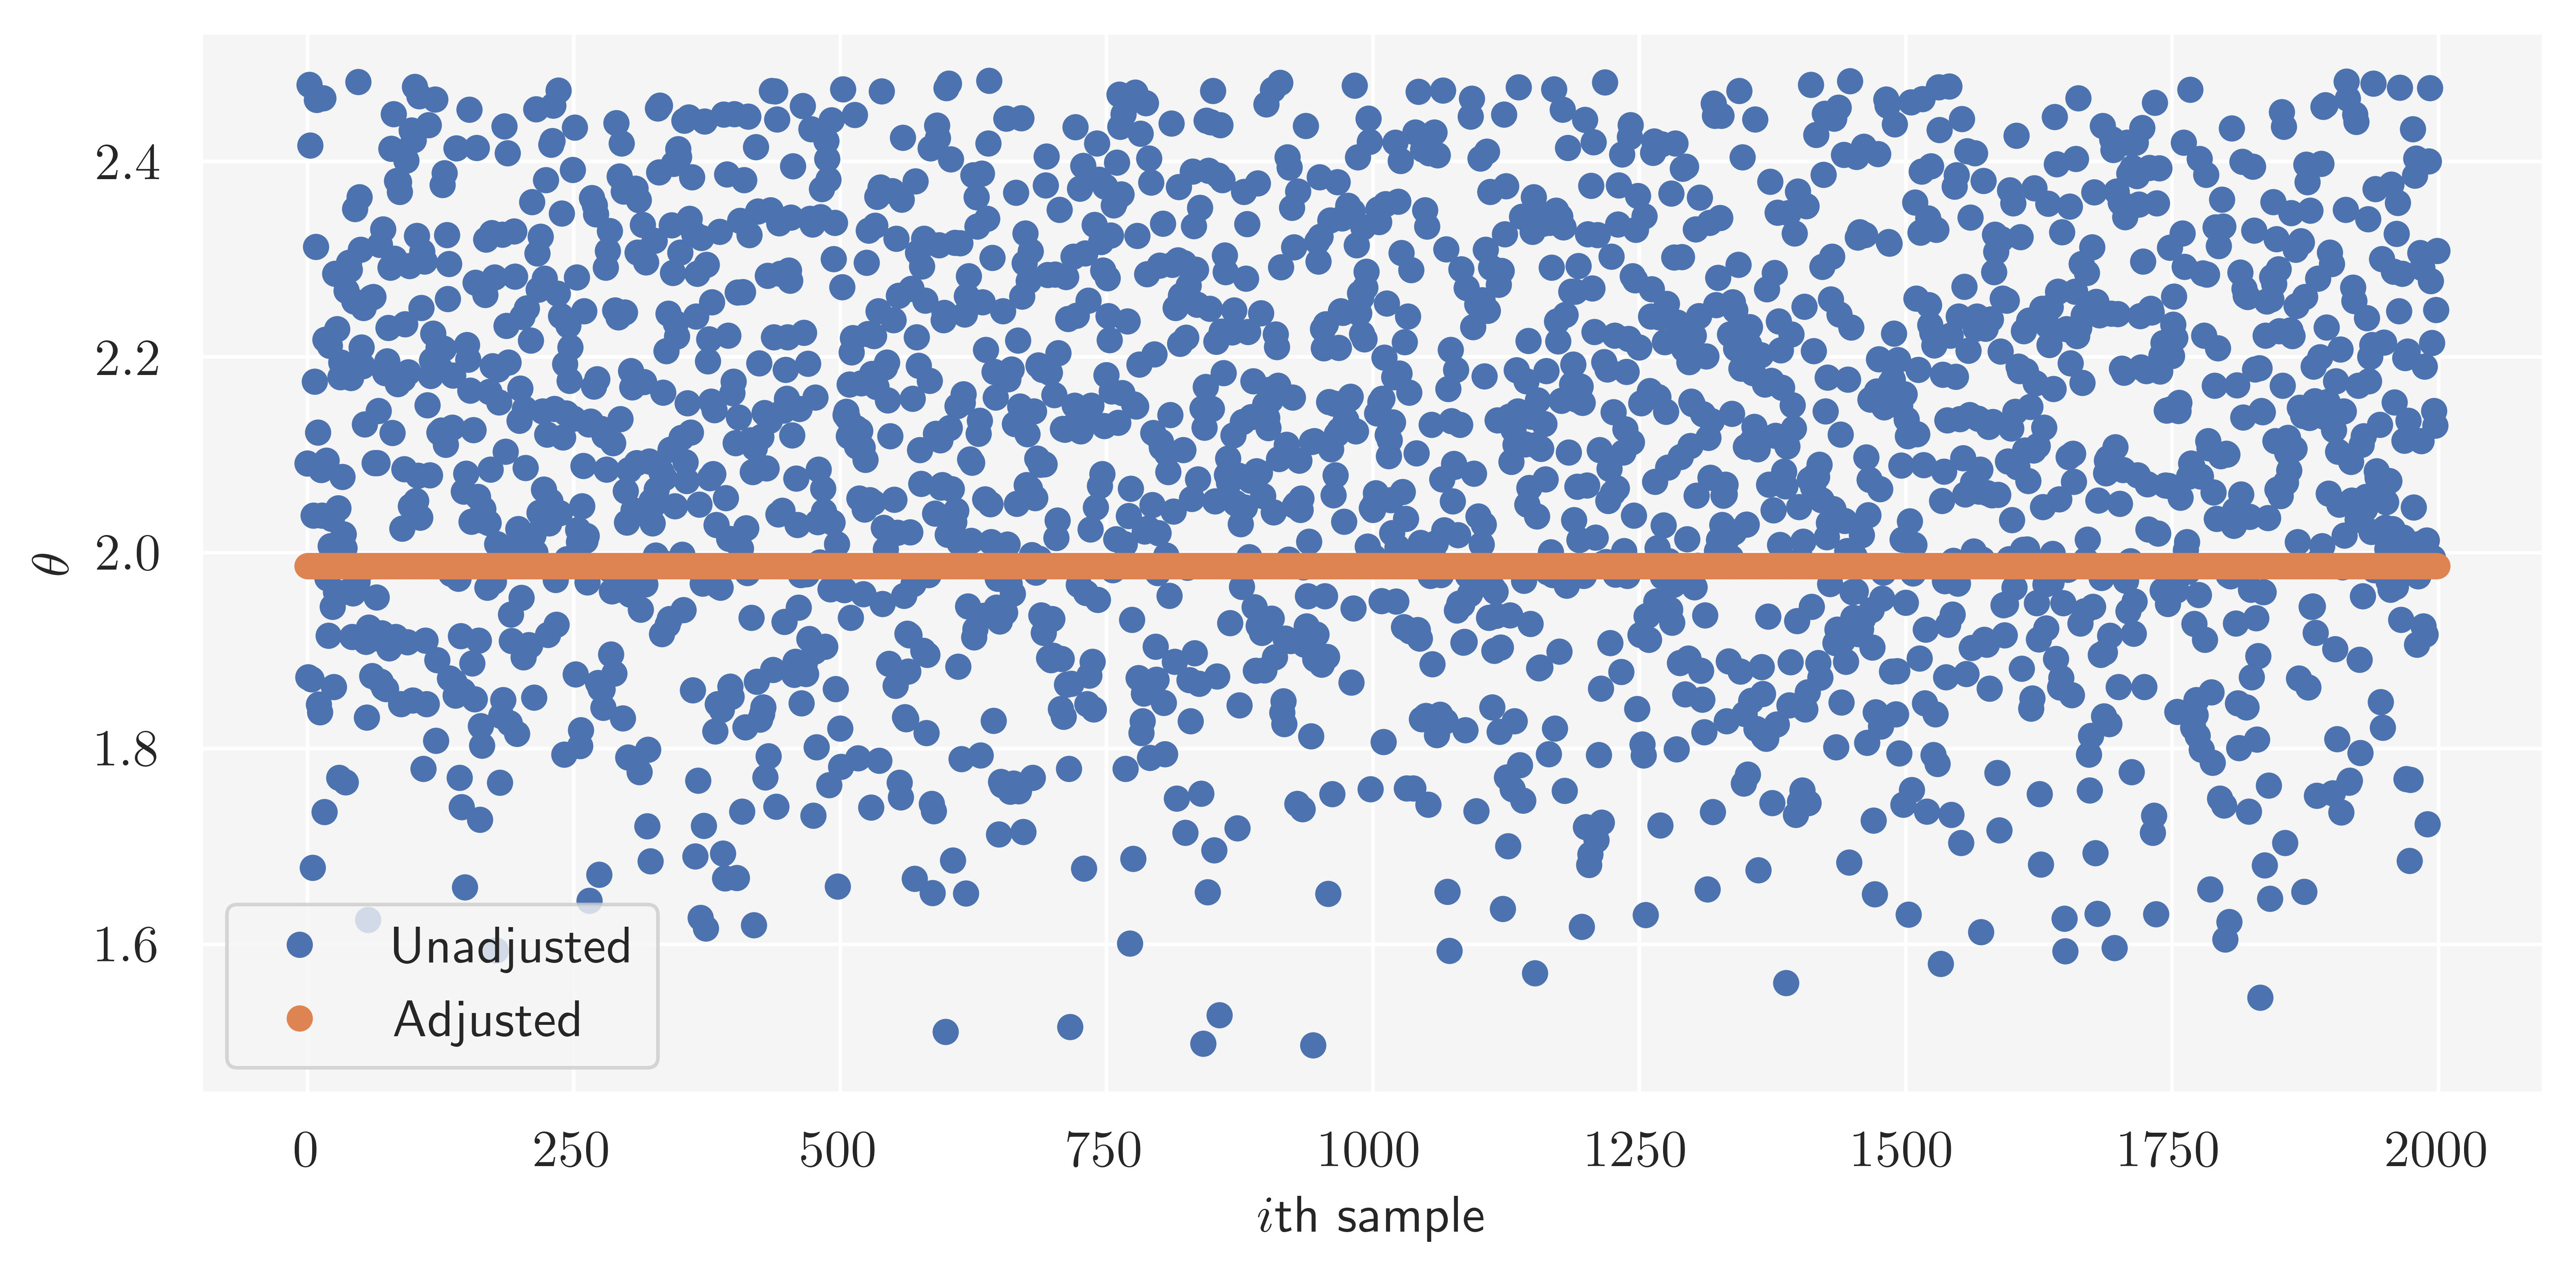

In [36]:
fig = plt.figure(figsize=(8, 4), tight_layout=True, dpi=800)
plt.plot(posterior_samples, 'o', label="Unadjusted")
plt.plot(theta_adjusted, 'o', label="Adjusted")
plt.ylabel(r"$\theta$")
plt.xlabel(r"$i$th sample")
plt.legend()
plt.show()

/Users/nicolai/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


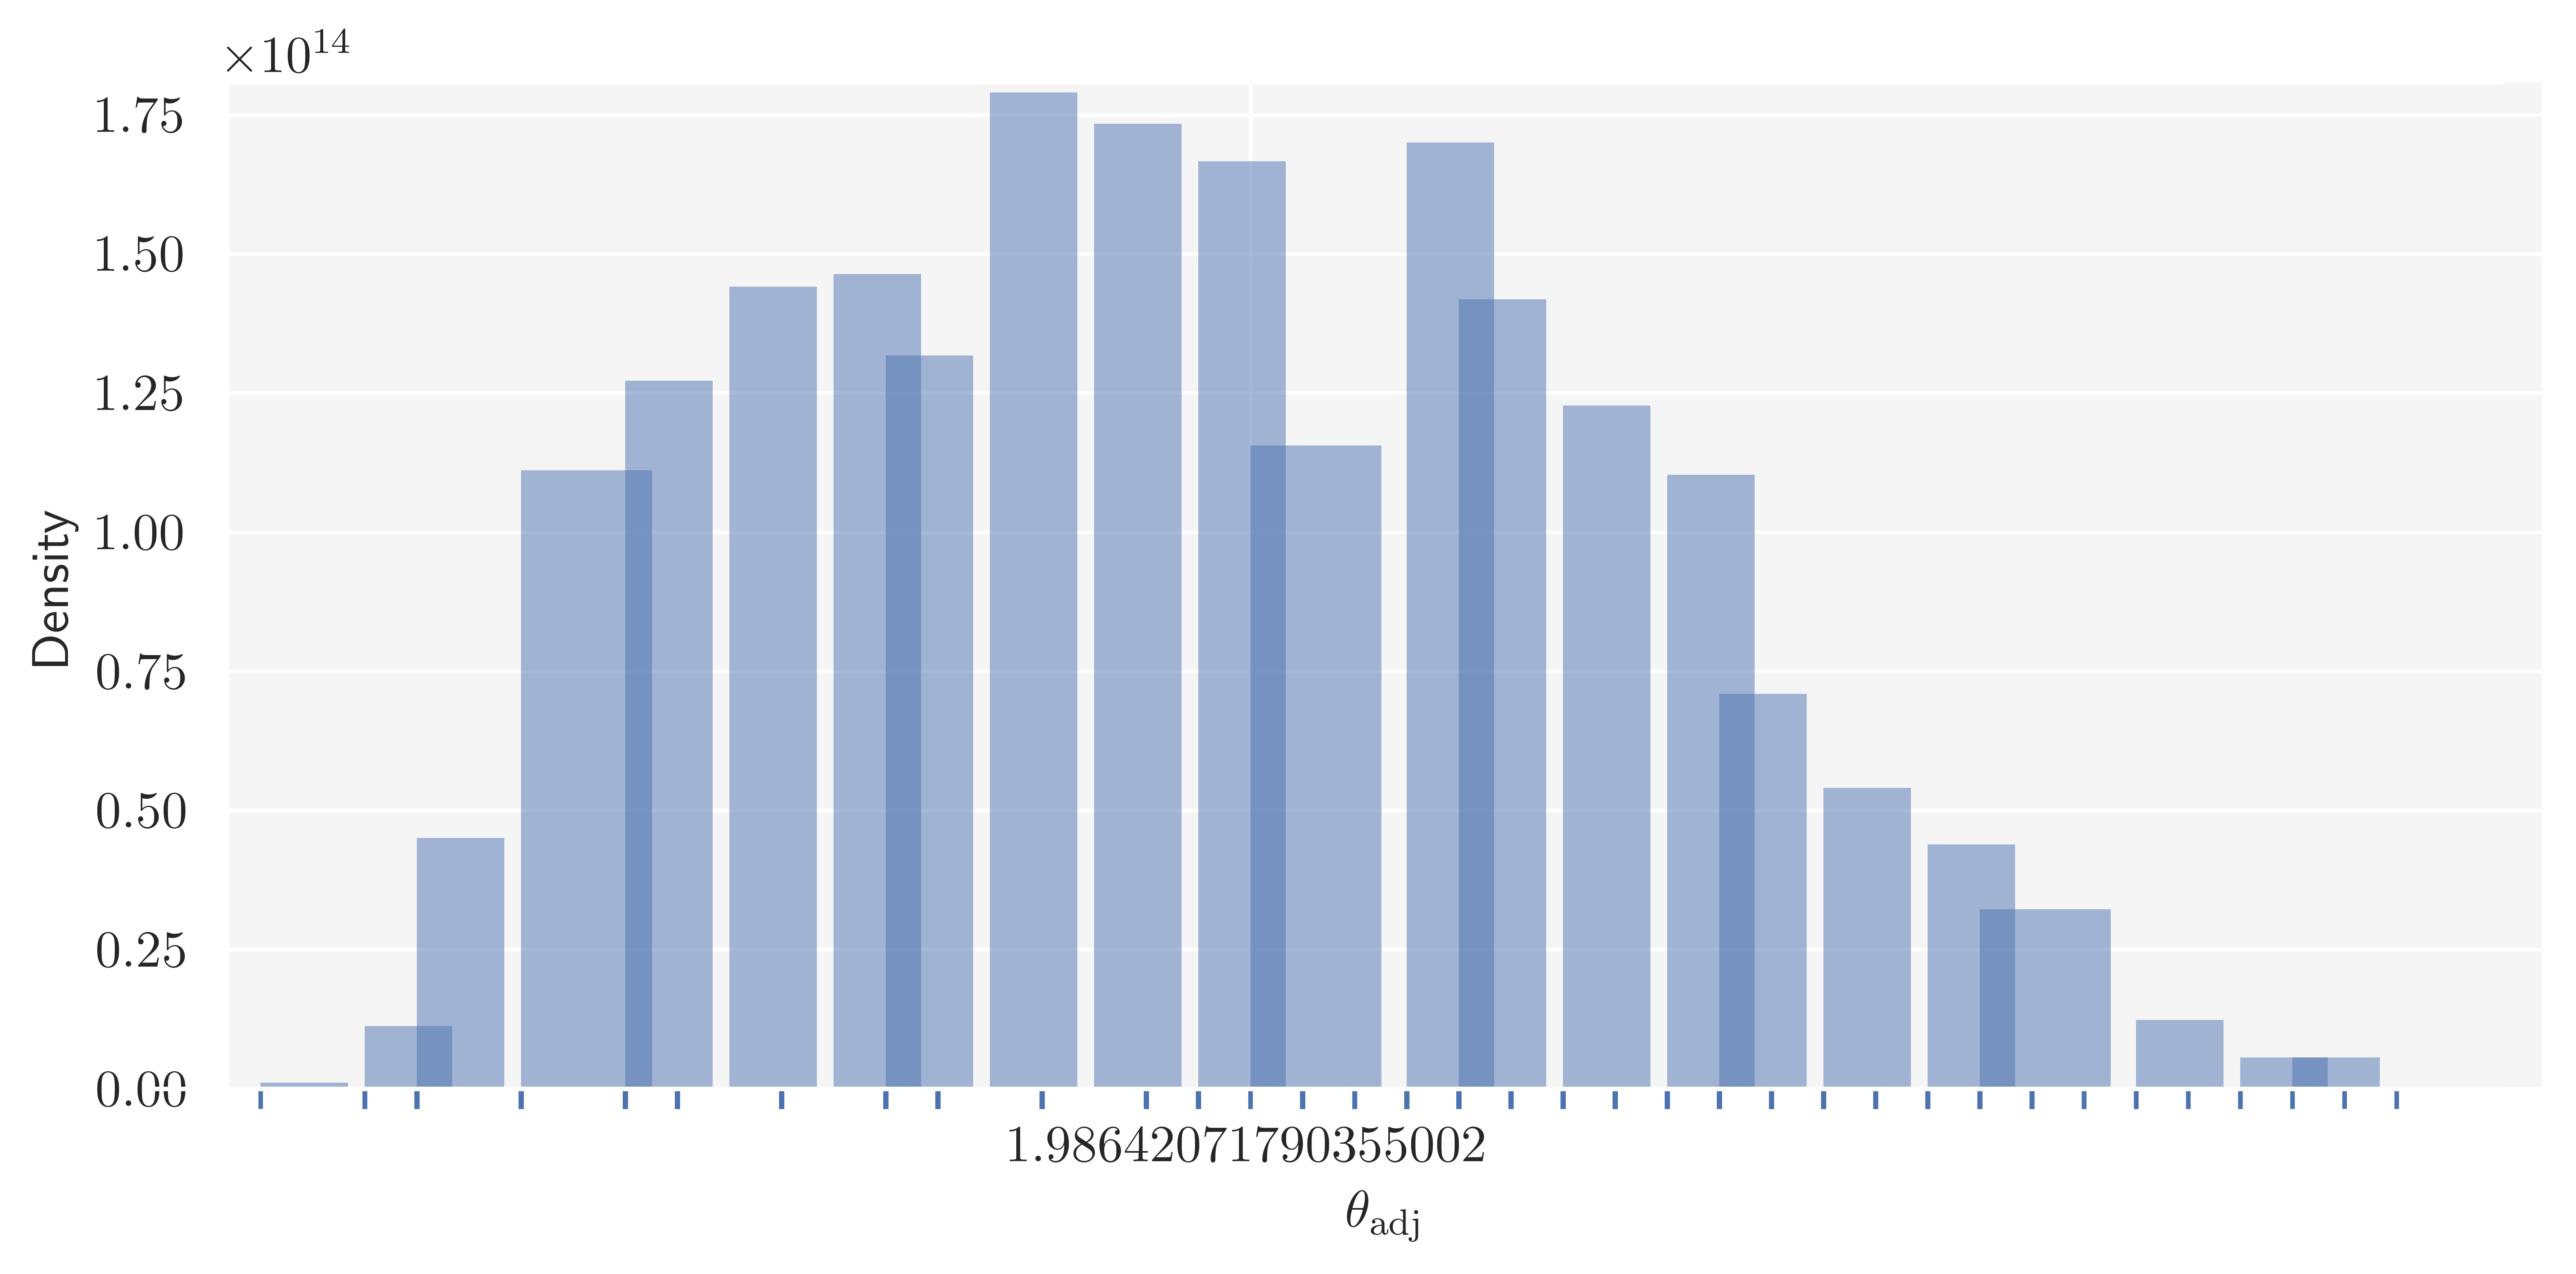

In [37]:
fig, ax = plt.subplots(figsize=(8, 4), tight_layout=True, dpi=800)
sns.histplot(data=theta_adjusted, stat="density", kde=True, ax=ax)
sns.rugplot(data=theta_adjusted, ax=ax, height=-.02, clip_on=False)
ax.set_xlabel(r"$\theta_\mathrm{adj}$")
plt.show()

/Users/nicolai/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


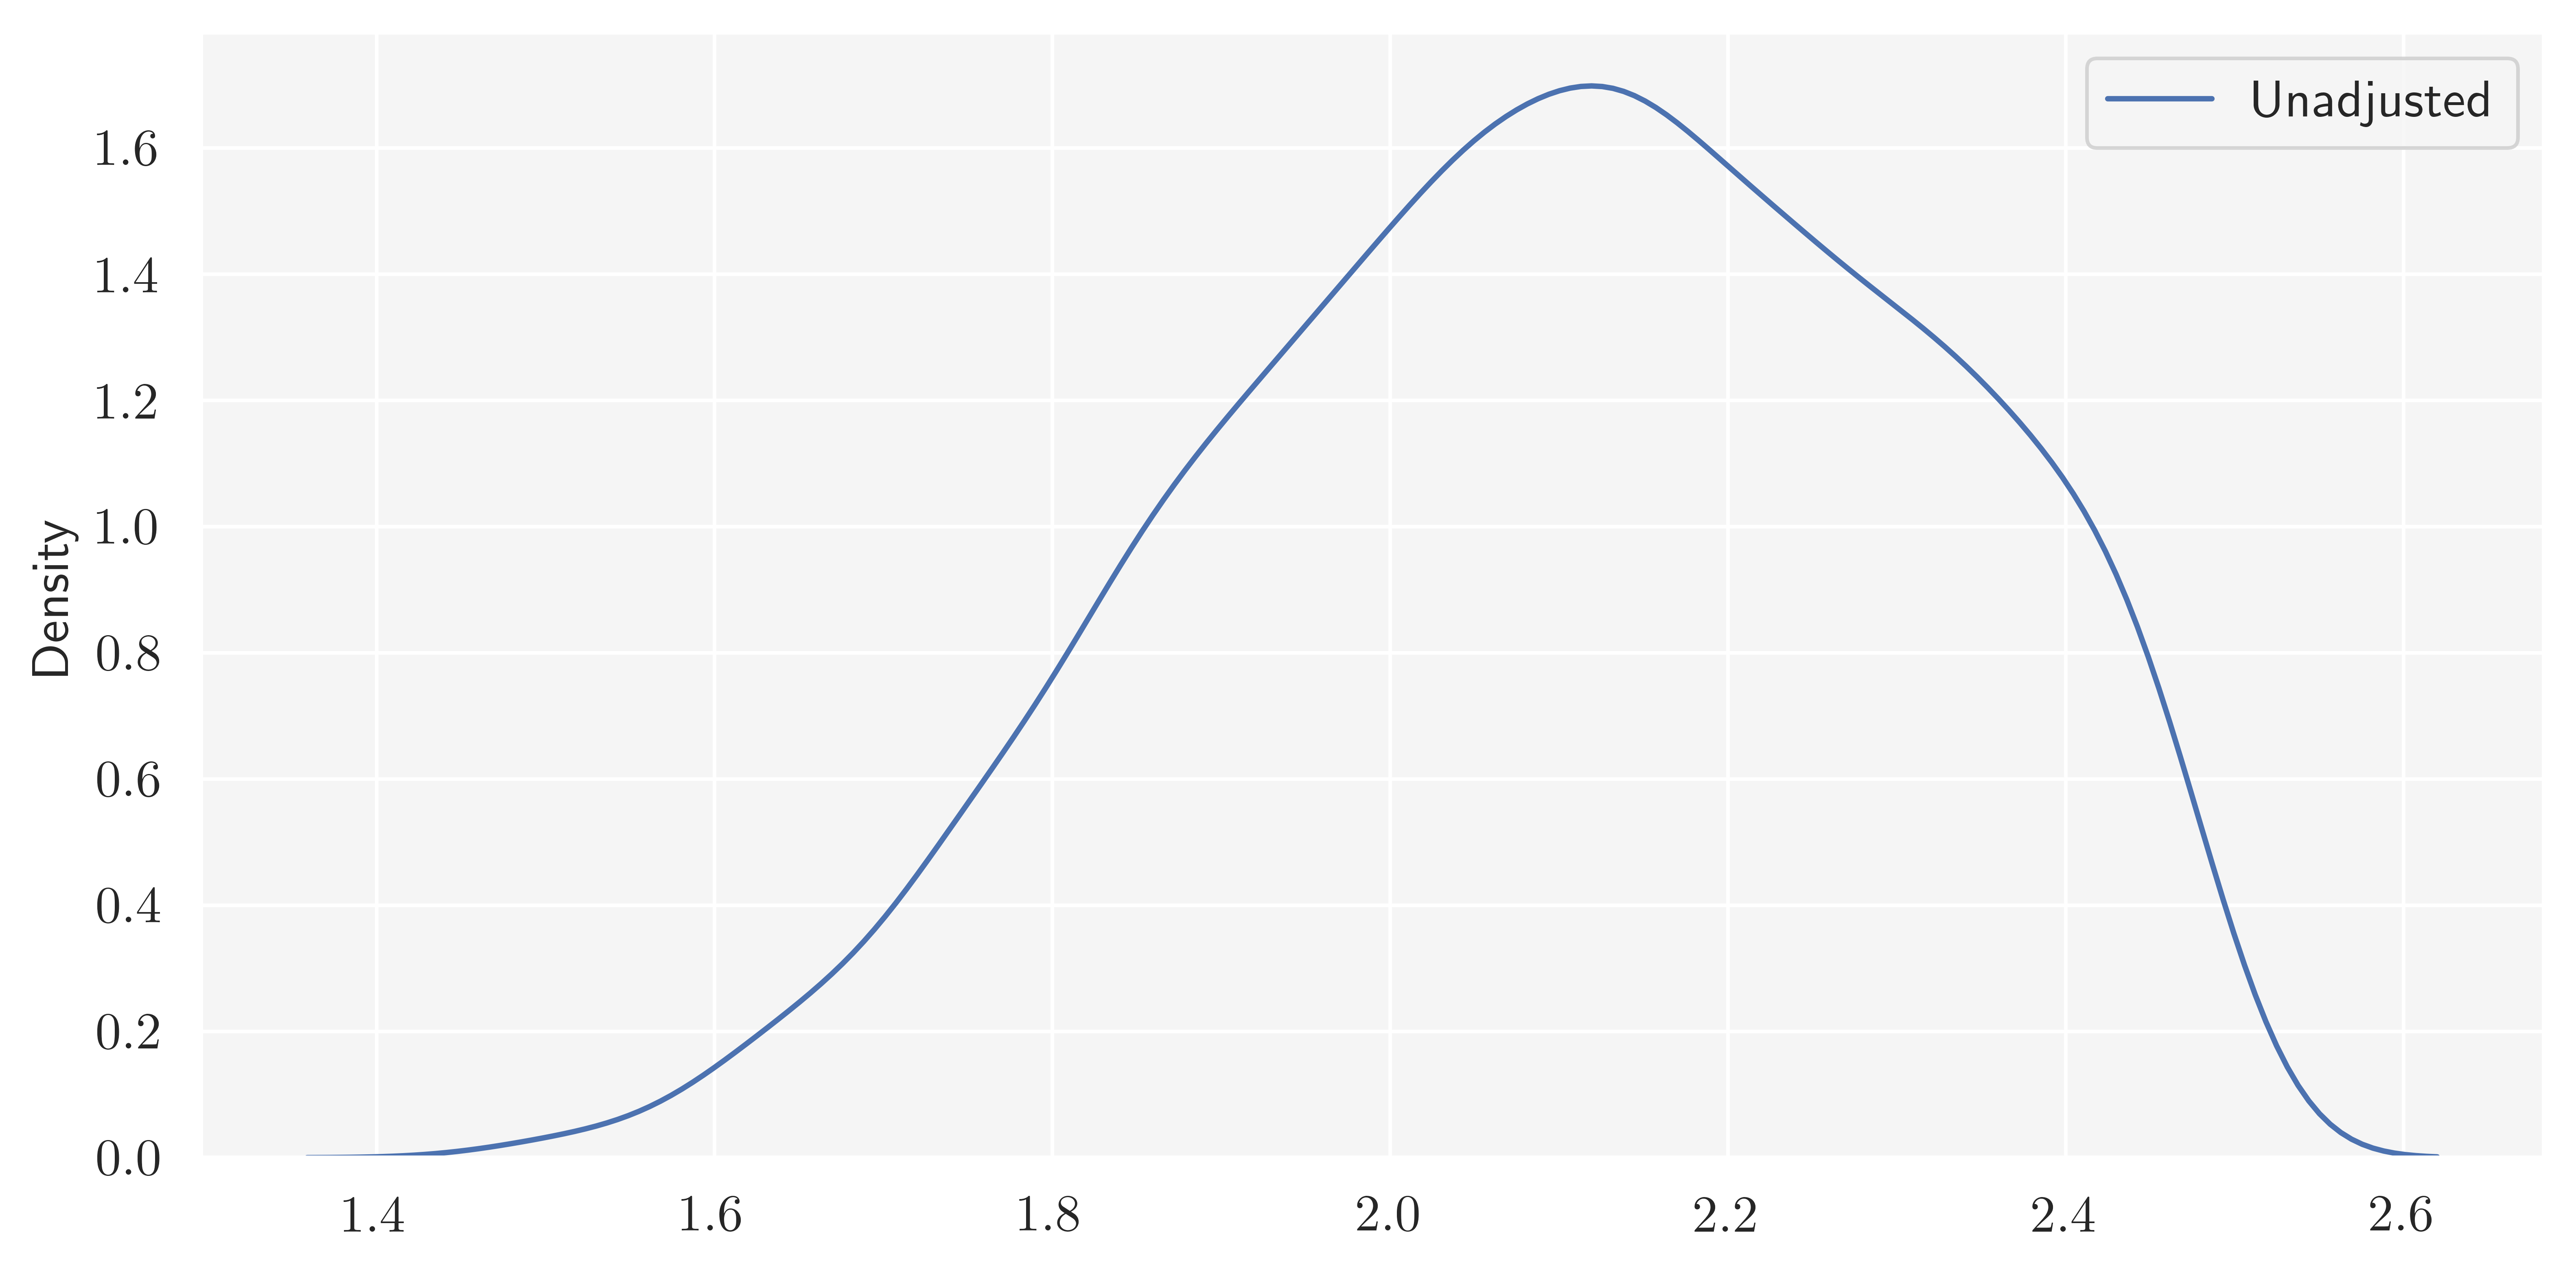

In [38]:
fig, ax = plt.subplots(figsize=(8, 4), tight_layout=True, dpi=800)
sns.kdeplot(data=posterior_samples, ax=ax, label="Unadjusted")
sns.kdeplot(data=theta_adjusted, ax=ax, label="Adjusted")
plt.legend()
plt.show()

#### Localized Weighting

(2000,)
(2000,)


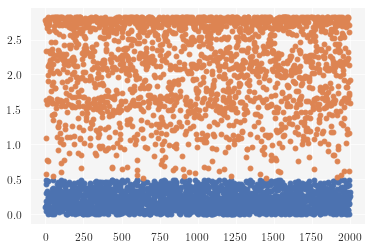

In [76]:
dist = journal.sampler_results["distance"].to_numpy()
print(dist.shape)

k_dist = stats.gaussian_kde(dist)

print(k_dist(dist).shape)

plt.plot(dist, 'o')
plt.plot(k_dist(dist), 'o')
plt.show()

In [ ]:
def gaussian_kernel():

In [ ]:
# m is the No of training examples .
    m = X.shape[0] 
    
  # Initialising W as an identity matrix.
    w = np.mat(np.eye(m))

In [ ]:
// Epanechnikov
//   must multiply by 3/4
double 
epanechnikov(double x)
{
  if (fabs(x) < 1) {
    return 1-x*x;
  } else {
    return 0;
  }
}

// Gaussian kernel
//   must multiply by 1/sqrt(2*pi)
double 
gaussian(double x)
{
  return exp(-x*x/2);
}

In [ ]:
"""Post-processing for posterior samples from other ABC algorithms.

References
----------
Fundamentals and Recent Developments in Approximate Bayesian Computation
Lintusaari et. al
Syst Biol (2017) 66 (1): e66-e82.
https://doi.org/10.1093/sysbio/syw077

"""
import warnings

import numpy as np
from sklearn.linear_model import LinearRegression

from . import results

__all__ = ('LinearAdjustment', 'adjust_posterior')


class RegressionAdjustment(object):
    """Base class for regression adjustments.

    Each parameter is assumed to be a scalar. A local regression is
    fitted for each parameter individually using the values of the
    summary statistics as the regressors.  The regression model can be
    any object implementing a `fit()` method. All keyword arguments
    given to the constructor are passed to the regression model.

    Subclasses need to implement the methods `_adjust` and
    `_input_variables`.  They must also specify the class variables
    `_regression_model` and `_name`.  See the individual documentation
    and the `LinearAdjustment` class for further detail.

    Parameters
    ----------
    kwargs**
      keyword arguments to pass to the regression model

    Attributes
    ----------
    regression_models
      a list of fitted regression model instances
    parameter_names
      a list of parameter names
    sample
      the sample object from an ABC algorithm
    X
      the regressors for the regression model

    """

    _regression_model = None
    _name = 'RegressionAdjustment'

    def __init__(self, **kwargs):
        self._model_kwargs = kwargs
        self._fitted = False
        self.regression_models = []
        self._X = None
        self._sample = None
        self._parameter_names = None
        self._finite = []

    @property
    def parameter_names(self):
        self._check_fitted()
        return self._parameter_names

    @property
    def sample(self):
        self._check_fitted()
        return self._sample

    @property
    def X(self):
        self._check_fitted()
        return self._X

    def _check_fitted(self):
        if not self._fitted:
            raise ValueError("The regression model must be fitted first. " "Use the fit() method.")

    def fit(self, sample, model, summary_names, parameter_names=None):
        """Fit a regression adjustment model to the posterior sample.

        Non-finite values in the summary statistics and parameters
        will be omitted.

        Parameters
        ----------
        sample : elfi.methods.Sample
          a sample object from an ABC method
        model : elfi.ElfiModel
          the inference model
        summary_names : list[str]
          a list of names for the summary nodes
        parameter_names : list[str] (optional)
          a list of parameter names

        """
        self._X = self._input_variables(model, sample, summary_names)
        self._sample = sample
        self._parameter_names = parameter_names or sample.parameter_names
        self._get_finite()

        for pair in self._pairs():
            self.regression_models.append(self._fit1(*pair))

        self._fitted = True

    def _fit1(self, X, y):
        return self._regression_model(**self._model_kwargs).fit(X, y)

    def _pairs(self):
        # TODO: Access the variables through the getters
        for (i, name) in enumerate(self._parameter_names):
            X = self._X[self._finite[i], :]
            p = self._sample.outputs[name][self._finite[i]]
            yield X, p

    def adjust(self):
        """Adjust the posterior.

        Only the non-finite values used to fit the regression model
        will be adjusted.

        Returns
        -------
          a Sample object containing the adjusted posterior

        """
        outputs = {}
        for (i, name) in enumerate(self.parameter_names):
            theta_i = self.sample.outputs[name][self._finite[i]]
            adjusted = self._adjust(i, theta_i, self.regression_models[i])
            outputs[name] = adjusted

        res = results.Sample(
            method_name=self._name, outputs=outputs, parameter_names=self._parameter_names)
        return res

    def _adjust(self, i, theta_i, regression_model):
        """Adjust a single parameter using a fitted regression model.

        Parameters
        ----------
        i : int
          the index of the parameter
        theta_i : np.ndarray
          a vector of parameter values to adjust
        regression_model
          a fitted regression model

        Returns
        -------
        adjusted_theta_i : np.ndarray
          an adjusted version of the parameter values

        """
        raise NotImplementedError

    def _input_variables(self, model, sample, summary_names):
        """Construct a matrix of regressors.

        Parameters
        ----------
        model : elfi.ElfiModel
          the inference model
        sample
          a sample object from an ABC algorithm
        summary_names : list[str]
          names of the summary nodes

        Returns
        -------
        X
          a numpy array of regressors

        """
        raise NotImplementedError

    def _get_finite(self):
        # TODO: Access the variables through the getters
        finite_inputs = np.isfinite(self._X).all(axis=1)
        finite = [
            finite_inputs & np.isfinite(self._sample.outputs[p]) for p in self._parameter_names
        ]
        all_finite = all(map(all, finite))
        self._finite = finite
        if not (all(finite_inputs) and all_finite):
            warnings.warn("Non-finite inputs and outputs will be omitted.")


class LinearAdjustment(RegressionAdjustment):
    """Regression adjustment using a local linear model."""

    _regression_model = LinearRegression
    _name = 'LinearAdjustment'

    def _adjust(self, i, theta_i, regression_model):
        b = regression_model.coef_
        return theta_i - self.X[self._finite[i], :].dot(b)

    def _input_variables(self, model, sample, summary_names):
        """Regress on the differences to the observed summaries."""
        observed_summaries = np.stack([model[s].observed for s in summary_names], axis=1)
        summaries = np.stack([sample.outputs[name] for name in summary_names], axis=1)
        return summaries - observed_summaries



def adjust_posterior(sample, model, summary_names, parameter_names=None, adjustment='linear'):
    """Adjust the posterior using local regression.

    Note that the summary nodes need to be explicitly included to the
    sample object with the `output_names` keyword argument when performing
    the inference.

    Parameters
    ----------
    sample : elfi.methods.results.Sample
      a sample object from an ABC algorithm
    model : elfi.ElfiModel
      the inference model
    summary_names : list[str]
      names of the summary nodes
    parameter_names : list[str] (optional)
      names of the parameters
    adjustment : RegressionAdjustment or string
      a regression adjustment object or a string specification

      Accepted values for the string specification:
       - 'linear'

    Returns
    -------
    elfi.methods.results.Sample
      a Sample object with the adjusted posterior

    Examples
    --------
    >>> import elfi
    >>> from elfi.examples import gauss
    >>> m = gauss.get_model()
    >>> res = elfi.Rejection(m['d'], output_names=['ss_mean', 'ss_var'],
    ...                      batch_size=10).sample(500, bar=False)
    >>> adj = adjust_posterior(res, m, ['ss_mean', 'ss_var'], ['mu'], LinearAdjustment())

    """
    adjustment = _get_adjustment(adjustment)
    adjustment.fit(
        model=model, sample=sample, parameter_names=parameter_names, summary_names=summary_names)
    return adjustment.adjust()



def _get_adjustment(adjustment):
    adjustments = {'linear': LinearAdjustment}

    if isinstance(adjustment, RegressionAdjustment):
        return adjustment
    elif isinstance(adjustment, str):
        try:
            return adjustments.get(adjustment, None)()
        except TypeError:
            raise ValueError("Could not find " "adjustment method:{}".format(adjustment))